## Import

In [1]:
## IMPORT 

import os
import numpy as np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt, resample, savgol_filter
from scipy.stats import linregress, ttest_ind, pearsonr, wilcoxon
from scipy.optimize import curve_fit, minimize
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib as mpl
import h5py
from pathlib import Path
import glob
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.integrate import simpson
import matplotlib.cm as cm
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib.ticker import MaxNLocator
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

## plotting params

In [2]:
# Text   
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 20
mpl.rcParams['font.family'] = '.SF Camera'

# Boxes
mpl.rcParams['axes.spines.top']= False
mpl.rcParams['axes.spines.right']= False

# plt.rcParams['figure.figsize'] = [4, 5]
plt.rcParams['figure.dpi'] = 140

## data loading + sliding window function

In [3]:

#SAM
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/sam/preprocessed/'
sam_files = glob.glob(os.path.join(directory, "*.csv"))

sam_files

#EPM 
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/epm/JrGECO_EPM/preprocessed/'
epm_files = glob.glob(os.path.join(directory, "*.csv"))

epm_files

# SLIDING WINDOW FUNCTION
def create_sliding_window(df, signal_col, target_col, window_size, step_size=30):
    X, y = [], []
    for i in range(0, len(df) - window_size, step_size):
        window_signal = df[signal_col].iloc[i:i + window_size].values
        window_labels = df[target_col].iloc[i:i + window_size]
        if len(window_labels.unique()) == 1:  # Ensure all labels in the window are the same
            X.append(window_signal)
            y.append(window_labels.iloc[0])
    return np.array(X), np.array(y)

print(sam_files, epm_files)

['/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/sam/preprocessed/152_F_preprocessed.csv', '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/sam/preprocessed/71_F_preprocessed.csv', '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/sam/preprocessed/84_M_preprocessed.csv', '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/sam/preprocessed/151_F_preprocessed.csv', '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/sam/preprocessed/64_M_preprocessed.csv', '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/sam/preprocessed/67_M_preprocessed.csv', '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/sam/preprocessed/66_M_preprocessed.csv', '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/sam/preprocessed/65_M_preprocessed.csv', '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/sam/preprocessed/68_F_preprocessed.csv', '/Users/ossamagh

Accuracy: 0.9230769230769231
Precision for class 1: 0.3076923076923077

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      1130
         1.0       0.31      1.00      0.47        40

    accuracy                           0.92      1170
   macro avg       0.65      0.96      0.71      1170
weighted avg       0.98      0.92      0.94      1170


Confusion Matrix:
 [[1040   90]
 [   0   40]]


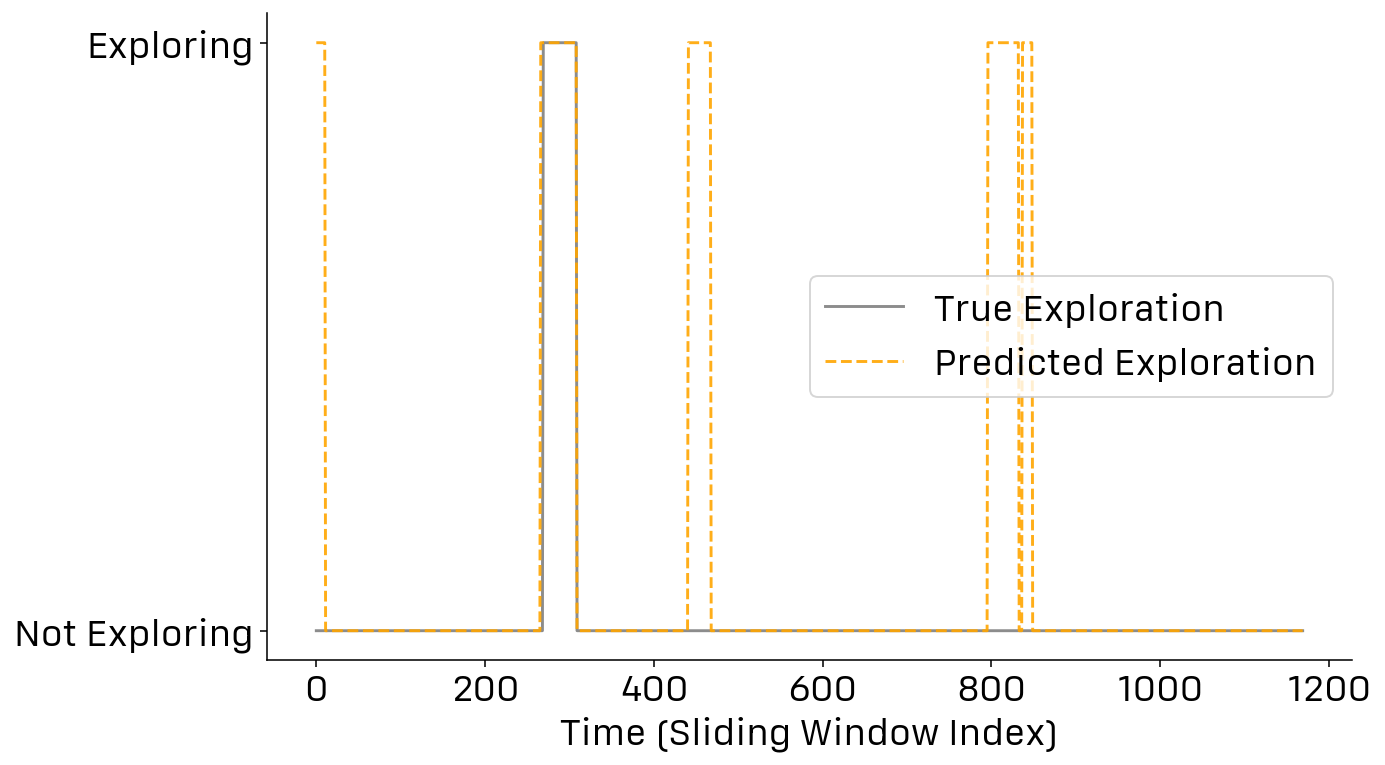

In [ ]:

# Load the training and testing data
epm = pd.read_csv('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/preprocessed/129_F_preprocessed.csv')
sam = pd.read_csv('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/preprocessed/129_F_preprocessed.csv')

# Preprocess the training data
epm.loc[epm['In Closed Arms'] == 1, 'exploration'] = 0
epm.loc[epm['In Closed Arms'] == 0, 'exploration'] = 1
epm = epm[['Zscoreg', 'Zscorer', 'Time', 'exploration', 'ID']]

# Preprocess the testing data
sam.loc[sam['In black'] == 1, 'exploration'] = 0
sam.loc[sam['In black'] == 0, 'exploration'] = 1
sam = sam[['Zscoreg', 'Zscorer', 'Time', 'exploration', 'ID']]


# Parameters
window_size = 300  # Sliding window size

# Prepare training and testing datasets
X_train, y_train = create_sliding_window(epm, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
X_test, y_test = create_sliding_window(sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)


# Oversample the training data
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


# Train the SVM model
svm_model = LogisticRegression(random_state=42, C=0.001, max_iter=50000)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred = svm_model.predict(X_test)


# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision for class 1:", precision_score(y_test, y_pred, pos_label=1))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='True Exploration', color='grey', alpha=0.9)
plt.plot(range(len(y_test)), y_pred, label='Predicted Exploration', color='orange', linestyle='--', alpha=0.9)
plt.xlabel('Time (Sliding Window Index)')
plt.yticks([0, 1], ['Not Exploring', 'Exploring'])
plt.legend()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/SAMtoEPM_walkrep1028.pdf', format='pdf')
plt.show()

Accuracy: 0.9721074380165289
Precision for class 1: 0.4186046511627907

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.99       948
         1.0       0.42      0.90      0.57        20

    accuracy                           0.97       968
   macro avg       0.71      0.94      0.78       968
weighted avg       0.99      0.97      0.98       968


Confusion Matrix:
 [[923  25]
 [  2  18]]


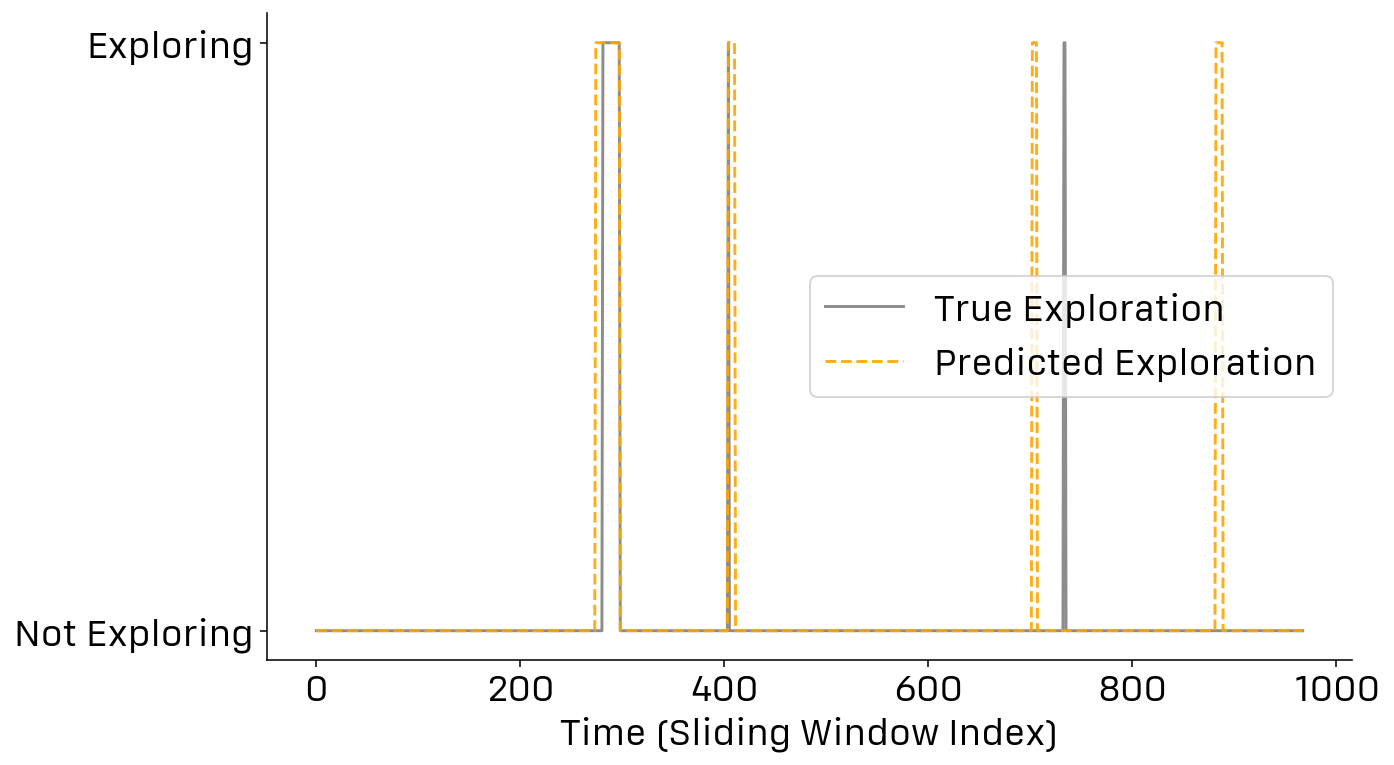

In [71]:

# Load the training and testing data
epm = pd.read_csv('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/EPM_FP/EPM_BLA/preprocessed/129_F_preprocessed.csv')
sam = pd.read_csv('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/SAM_FP/SAM_BLA/preprocessed/129_F_preprocessed.csv')

# Preprocess the training data
epm.loc[epm['In Closed Arms'] == 1, 'exploration'] = 0
epm.loc[epm['In Closed Arms'] == 0, 'exploration'] = 1
epm = epm[['Zscoreg', 'Time', 'exploration', 'ID']]

# Preprocess the testing data
sam.loc[sam['In black'] == 1, 'exploration'] = 0
sam.loc[sam['In black'] == 0, 'exploration'] = 1
sam = sam[['Zscoreg', 'Time', 'exploration', 'ID']]


# Parameters
window_size = 300  # Sliding window size

# Prepare training and testing datasets
X_train, y_train = create_sliding_window(sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
X_test, y_test = create_sliding_window(epm, signal_col='Zscoreg', target_col='exploration', window_size=window_size)


# Oversample the training data
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


# Train the SVM model
svm_model = LogisticRegression(random_state=42, C=0.001, max_iter=50000)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred = svm_model.predict(X_test)


# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision for class 1:", precision_score(y_test, y_pred, pos_label=1))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize predictions vs true values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='True Exploration', color='grey', alpha=0.9)
plt.plot(range(len(y_test)), y_pred, label='Predicted Exploration', color='orange', linestyle='--', alpha=0.9)
plt.xlabel('Time (Sliding Window Index)')
plt.yticks([0, 1], ['Not Exploring', 'Exploring'])
plt.legend()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_walkrep1035.pdf', format='pdf')
plt.show()

In [61]:

# # Initialize results storage
# confusion_matrices = []
# shuffled_confusion_matrices = []
# results = {'ID': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], '1_f1': [], '0_f1': [],
#            'Shuffled_ID': [], 'Shuffled_Accuracy': [], 'Shuffled_Precision': [], 'Shuffled_Recall': [],
#            'Shuffled_F1': [], 'Shuffled_1_f1': [], 'Shuffled_0_f1': []}

# num_repeats = 1 # number of under sampling repeats

# for efile, sfile in zip(epm_files, sam_files):
#     epm = pd.read_csv(efile)
#     sam = pd.read_csv(sfile)
#     id = epm['ID'].iloc[0]

#         # Label assignment 
#     epm['exploration'] = np.where(epm['In Closed Arms'] == 1, 0, 1)
#     sam['exploration'] = np.where(sam['In black'] == 1, 0, 1)

#     epm = epm[['Zscoreg', 'Time', 'exploration', 'ID']]
#     sam = sam[['Zscoreg', 'Time', 'exploration', 'ID']]

#     # # Preprocessing 
#     # epm.loc[epm['In Closed Arms'] == 1, 'exploration'] = 0
#     # epm.loc[epm['In Closed Arms'] == 0, 'exploration'] = 1
#     # epm = epm[['Zscoreg', 'Time', 'exploration', 'ID']]


#     # sam.loc[sam['In black'] == 1, 'exploration'] = 0
#     # sam.loc[sam['In black'] == 0, 'exploration'] = 1
#     # sam = sam[['Zscoreg', 'Time', 'exploration', 'ID']]

#     window_size = 300

#     X_train, y_train = create_sliding_window(sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
#     X_test, y_test = create_sliding_window(epm, signal_col='Zscoreg', target_col='exploration', window_size=window_size)


#     for repeat_idx in range(num_repeats):
#         print(f"Repeat {repeat_idx + 1}/{num_repeats}")

#         # Random undersampling
#         undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
#         X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

#         # Hyperparameter tuning
#         param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
#         lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
#         grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
#         grid_search.fit(X_train_resampled, y_train_resampled)

#         # Get best model
#         best_model = grid_search.best_estimator_
#         best_model.fit(X_train_resampled, y_train_resampled)
#         y_pred = best_model.predict(X_test)

#         # Evaluate model
#         cm = confusion_matrix(y_test, y_pred, normalize='true')
#         confusion_matrices.append(cm)

#         report = classification_report(y_test, y_pred, output_dict=True)
#         results['ID'].append(id)
#         results['Accuracy'].append(report['accuracy'])
#         results['Precision'].append(report['weighted avg']['precision'])
#         results['Recall'].append(report['weighted avg']['recall'])
#         results['F1'].append(report['weighted avg']['f1-score'])
#         results['1_f1'].append(report['1']['f1-score'])
#         results['0_f1'].append(report['0']['f1-score'])

#         print(classification_report(y_test, y_pred))
#         print(confusion_matrix(y_test, y_pred, normalize='true'))

#         print(f'mouse ID: {id}')

#         # Plot predicted vs real data
#         plt.figure(figsize=(8, 6))
#         plt.plot(y_test, label='Real Data', alpha=0.7)
#         plt.plot(y_pred, label='Predicted Data', alpha=0.7)
#         plt.legend()
#         plt.xlabel('Sample Index')
#         plt.ylabel('Class')
#         plt.title('Predicted vs Real Data')
#         plt.show()

#         # Shuffle and evaluate
#         num_permutations = 50
#         shuffled_cm_list = []
#         shuffled_results_list = []

#         for i in range(num_permutations):
#             np.random.seed(42 + i)
#             np.random.shuffle(y_train_resampled)

#             best_model.fit(X_train_resampled, y_train_resampled)
#             y_pred_shuffled = best_model.predict(X_test)

#             shuffled_report = classification_report(y_test, y_pred_shuffled, output_dict=True)
#             shuffled_results_list.append({
#                 'Shuffled_Accuracy': shuffled_report['accuracy'],
#                 'Shuffled_Precision': shuffled_report['weighted avg']['precision'],
#                 'Shuffled_Recall': shuffled_report['weighted avg']['recall'],
#                 'Shuffled_F1': shuffled_report['weighted avg']['f1-score'],
#                 'Shuffled_1_f1': shuffled_report['1']['f1-score'],
#                 'Shuffled_0_f1': shuffled_report['0']['f1-score']
#             })

#             cm_shuffled = confusion_matrix(y_test, y_pred_shuffled, normalize='true')
#             shuffled_cm_list.append(cm_shuffled)

#         avg_shuffled_cm = np.mean(shuffled_cm_list, axis=0)
#         shuffled_average_results = {
#             key: np.mean([res[key] for res in shuffled_results_list]) for key in shuffled_results_list[0]
#         }

#         results['Shuffled_ID'].append(id)
#         results['Shuffled_Accuracy'].append(shuffled_average_results['Shuffled_Accuracy'])
#         results['Shuffled_Precision'].append(shuffled_average_results['Shuffled_Precision'])
#         results['Shuffled_Recall'].append(shuffled_average_results['Shuffled_Recall'])
#         results['Shuffled_F1'].append(shuffled_average_results['Shuffled_F1'])
#         results['Shuffled_1_f1'].append(shuffled_average_results['Shuffled_1_f1'])
#         results['Shuffled_0_f1'].append(shuffled_average_results['Shuffled_0_f1'])

#         shuffled_confusion_matrices.append(avg_shuffled_cm)

# # Average confusion matrices
# average_cm = np.mean(confusion_matrices, axis=0)
# shuffled_average_cm = np.mean(shuffled_confusion_matrices, axis=0)

# # Calculate average results for each ID
# average_results = pd.DataFrame(results).groupby('ID').mean()
# print(average_results)

# # Plot confusion matrices
# plt.figure(figsize=(8, 6))
# sns.heatmap(average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
#             xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Average Confusion Matrix (Normalized)')
# # plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_CM.pdf', format='pdf')
# plt.show()

# plt.figure(figsize=(8, 6))
# sns.heatmap(shuffled_average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
#             xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Average Shuffled Confusion Matrix (Normalized)')
# plt.show()

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3

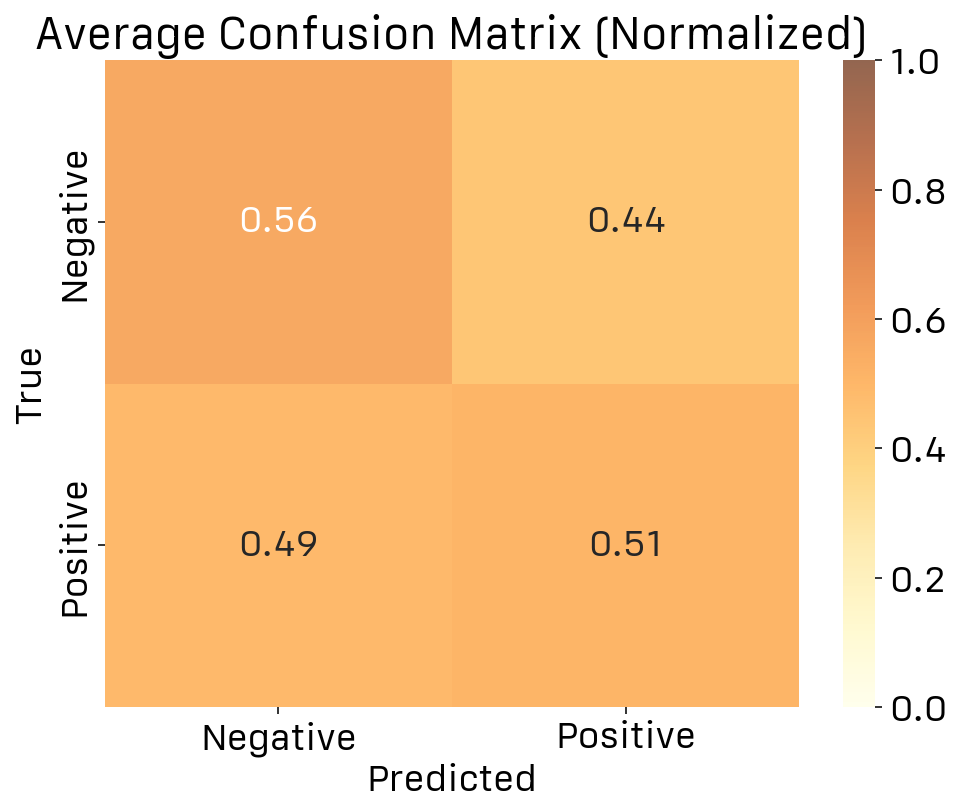

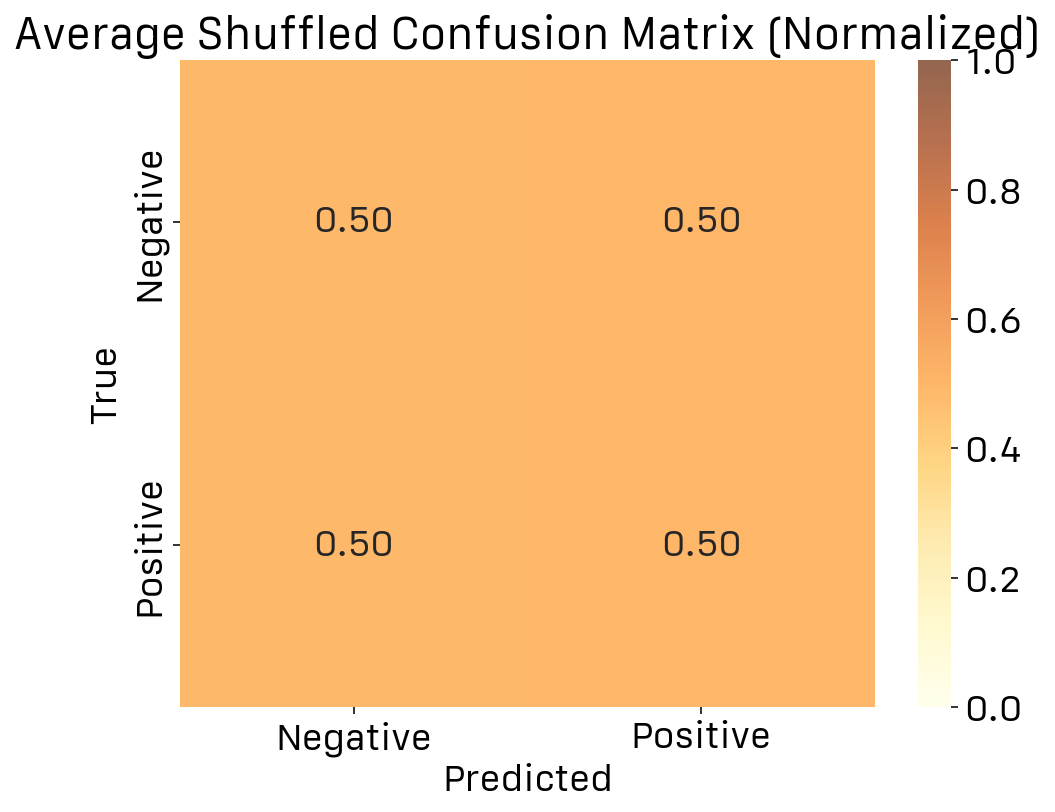

In [54]:
## One decoder per mouse, output average confusion matrix 

# Initialize results storage
confusion_matrices = []
shuffled_confusion_matrices = []
results = {'ID': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], '1_f1': [], '0_f1': [], 'AUC_ROC': [],
           'Shuffled_ID': [], 'Shuffled_Accuracy': [], 'Shuffled_Precision': [], 'Shuffled_Recall': [],
           'Shuffled_F1': [], 'Shuffled_1_f1': [], 'Shuffled_0_f1': [], 'Shuffled_AUC_ROC': []}

num_repeats = 10  # number of under-sampling repeats

for efile, sfile in zip(epm_files, sam_files):
    epm = pd.read_csv(efile)
    sam = pd.read_csv(sfile)
    id = epm['ID'].iloc[0]

    # Label assignment
    epm['exploration'] = np.where(epm['In Closed Arms'] == 1, 0, 1)
    sam['exploration'] = np.where(sam['In black'] == 1, 0, 1)

    epm = epm[['Zscorer', 'Zscoreg', 'Time', 'exploration', 'ID']]
    sam = sam[['Zscorer', 'Zscoreg', 'Time', 'exploration', 'ID']]

    window_size = 300

    X_train, y_train = create_sliding_window(epm, signal_col='Zscorer', target_col='exploration', window_size=window_size)
    X_test, y_test = create_sliding_window(sam, signal_col='Zscorer', target_col='exploration', window_size=window_size)

    for repeat_idx in range(num_repeats):
        print(f"Repeat {repeat_idx + 1}/{num_repeats}")

        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Get best model
        best_model = grid_search.best_estimator_
        best_model.fit(X_train_resampled, y_train_resampled)
        
        # Predict probabilities for AUC-ROC calculation
        y_pred_proba = best_model.predict_proba(X_test)
        y_pred = best_model.predict(X_test)

        # Compute AUC-ROC
        auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

        # Evaluate model
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        confusion_matrices.append(cm)

        report = classification_report(y_test, y_pred, output_dict=True)
        results['ID'].append(id)
        results['Accuracy'].append(report['accuracy'])
        results['Precision'].append(report['weighted avg']['precision'])
        results['Recall'].append(report['weighted avg']['recall'])
        results['F1'].append(report['weighted avg']['f1-score'])
        results['1_f1'].append(report['1']['f1-score'])
        results['0_f1'].append(report['0']['f1-score'])
        results['AUC_ROC'].append(auc_roc)

        # Shuffle and evaluate
        num_permutations = 50
        shuffled_cm_list = []
        shuffled_results_list = []

        for i in range(num_permutations):
            np.random.seed(42 + i)
            np.random.shuffle(y_train_resampled)

            best_model.fit(X_train_resampled, y_train_resampled)
            y_pred_shuffled_proba = best_model.predict_proba(X_test)
            y_pred_shuffled = best_model.predict(X_test)

            shuffled_auc_roc = roc_auc_score(y_test, y_pred_shuffled_proba[:, 1])

            shuffled_report = classification_report(y_test, y_pred_shuffled, output_dict=True)
            shuffled_results_list.append({
                'Shuffled_Accuracy': shuffled_report['accuracy'],
                'Shuffled_Precision': shuffled_report['weighted avg']['precision'],
                'Shuffled_Recall': shuffled_report['weighted avg']['recall'],
                'Shuffled_F1': shuffled_report['weighted avg']['f1-score'],
                'Shuffled_1_f1': shuffled_report['1']['f1-score'],
                'Shuffled_0_f1': shuffled_report['0']['f1-score'],
                'Shuffled_AUC_ROC': shuffled_auc_roc
            })

            cm_shuffled = confusion_matrix(y_test, y_pred_shuffled, normalize='true')
            shuffled_cm_list.append(cm_shuffled)

        avg_shuffled_cm = np.mean(shuffled_cm_list, axis=0)
        shuffled_average_results = {
            key: np.mean([res[key] for res in shuffled_results_list]) for key in shuffled_results_list[0]
        }

        results['Shuffled_ID'].append(id)
        results['Shuffled_Accuracy'].append(shuffled_average_results['Shuffled_Accuracy'])
        results['Shuffled_Precision'].append(shuffled_average_results['Shuffled_Precision'])
        results['Shuffled_Recall'].append(shuffled_average_results['Shuffled_Recall'])
        results['Shuffled_F1'].append(shuffled_average_results['Shuffled_F1'])
        results['Shuffled_1_f1'].append(shuffled_average_results['Shuffled_1_f1'])
        results['Shuffled_0_f1'].append(shuffled_average_results['Shuffled_0_f1'])
        results['Shuffled_AUC_ROC'].append(shuffled_average_results['Shuffled_AUC_ROC'])

        shuffled_confusion_matrices.append(avg_shuffled_cm)

# Average confusion matrices
average_cm = np.mean(confusion_matrices, axis=0)
shuffled_average_cm = np.mean(shuffled_confusion_matrices, axis=0)

# Calculate average results for each ID
average_results = pd.DataFrame(results).groupby('ID').mean()
print(average_results)

# Plot confusion matrices
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (Normalized)')
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jRGECOEPMtoSAM_CM.pdf', format='pdf')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(shuffled_average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Shuffled Confusion Matrix (Normalized)')
plt.show()


     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   0.553802   0.610478  0.553802  0.570239  0.394132  0.645127  0.553214   
64   0.525081   0.532227  0.525081  0.526776  0.475745  0.564977  0.540043   
65   0.611189   0.607721  0.611189  0.608982  0.505659  0.679484  0.637105   
66   0.472693   0.648091  0.472693  0.524740  0.240390  0.596166  0.475217   
67   0.460314   0.491073  0.460314  0.470761  0.342691  0.542060  0.424068   
68   0.536182   0.788822  0.536182  0.608475  0.245009  0.664209  0.556133   
70   0.562056   0.823206  0.562056  0.655603  0.114549  0.708681  0.446611   
71   0.615795   0.876403  0.615795  0.677581  0.362182  0.722638  0.810131   
84   0.639439   0.844046  0.639439  0.699412  0.330002  0.753202  0.731489   
150  0.489531   0.637796  0.489531  0.535099  0.252035  0.611875  0.444448   
151  0.500899   0.558435  0.500899  0.514990  0.404143  0.570247

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/4126731347.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


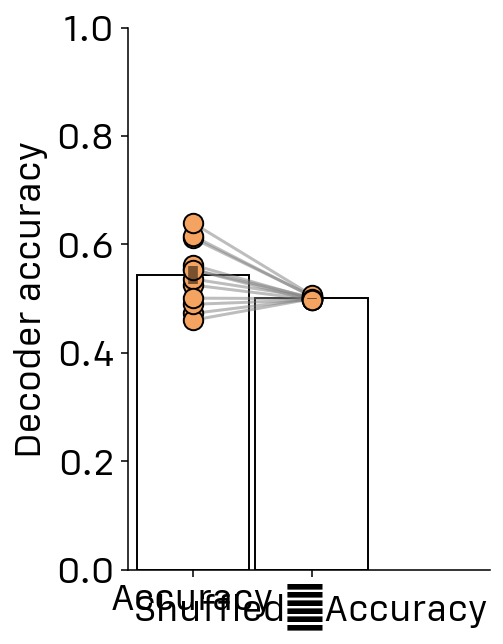

In [56]:

df = average_results.copy()
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Accuracy', 'Shuffled_Accuracy']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Accuracy'], df['Shuffled_Accuracy'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Accuracy'], row['Shuffled_Accuracy']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder accuracy')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/SAMtoEPM_Neuro_Accuracy.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   0.553802   0.610478  0.553802  0.570239  0.394132  0.645127  0.553214   
64   0.525081   0.532227  0.525081  0.526776  0.475745  0.564977  0.540043   
65   0.611189   0.607721  0.611189  0.608982  0.505659  0.679484  0.637105   
66   0.472693   0.648091  0.472693  0.524740  0.240390  0.596166  0.475217   
67   0.460314   0.491073  0.460314  0.470761  0.342691  0.542060  0.424068   
68   0.536182   0.788822  0.536182  0.608475  0.245009  0.664209  0.556133   
70   0.562056   0.823206  0.562056  0.655603  0.114549  0.708681  0.446611   
71   0.615795   0.876403  0.615795  0.677581  0.362182  0.722638  0.810131   
84   0.639439   0.844046  0.639439  0.699412  0.330002  0.753202  0.731489   
150  0.489531   0.637796  0.489531  0.535099  0.252035  0.611875  0.444448   
151  0.500899   0.558435  0.500899  0.514990  0.404143  0.570247

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/1319431693.py:30: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/1319431693.py:31: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Neuro_EPMtoSAM_F1.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


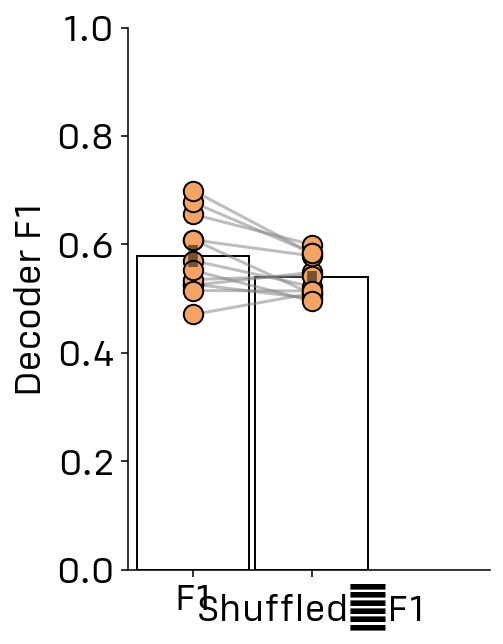

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from matplotlib.ticker import MaxNLocator

df = pd.DataFrame(average_results)
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['F1', 'Shuffled_F1']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['F1'], df['Shuffled_F1'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['F1'], row['Shuffled_F1']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder F1')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Neuro_EPMtoSAM_F1.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   0.553802   0.610478  0.553802  0.570239  0.394132  0.645127  0.553214   
64   0.525081   0.532227  0.525081  0.526776  0.475745  0.564977  0.540043   
65   0.611189   0.607721  0.611189  0.608982  0.505659  0.679484  0.637105   
66   0.472693   0.648091  0.472693  0.524740  0.240390  0.596166  0.475217   
67   0.460314   0.491073  0.460314  0.470761  0.342691  0.542060  0.424068   
68   0.536182   0.788822  0.536182  0.608475  0.245009  0.664209  0.556133   
70   0.562056   0.823206  0.562056  0.655603  0.114549  0.708681  0.446611   
71   0.615795   0.876403  0.615795  0.677581  0.362182  0.722638  0.810131   
84   0.639439   0.844046  0.639439  0.699412  0.330002  0.753202  0.731489   
150  0.489531   0.637796  0.489531  0.535099  0.252035  0.611875  0.444448   
151  0.500899   0.558435  0.500899  0.514990  0.404143  0.570247

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/2742185110.py:30: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


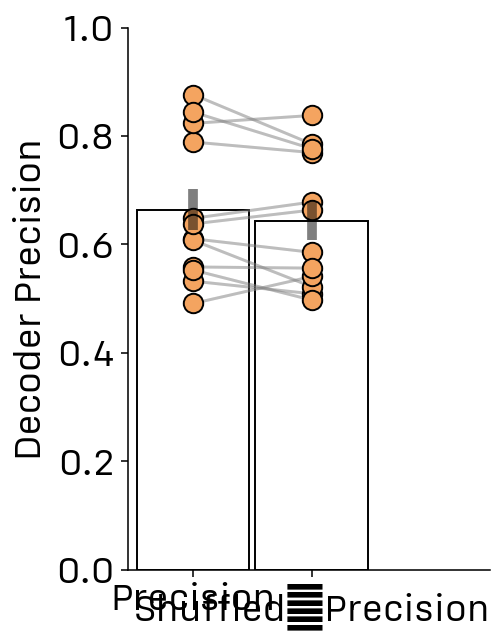

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from matplotlib.ticker import MaxNLocator

df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4, 5))
conditions = ['Precision', 'Shuffled_Precision']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Precision'], df['Shuffled_Precision'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
    zorder=0)
for condition in conditions:
    plt.scatter([condition] * len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Precision'], row['Shuffled_Precision']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder Precision')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55, 3 - 0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_Precision.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   0.553802   0.610478  0.553802  0.570239  0.394132  0.645127  0.553214   
64   0.525081   0.532227  0.525081  0.526776  0.475745  0.564977  0.540043   
65   0.611189   0.607721  0.611189  0.608982  0.505659  0.679484  0.637105   
66   0.472693   0.648091  0.472693  0.524740  0.240390  0.596166  0.475217   
67   0.460314   0.491073  0.460314  0.470761  0.342691  0.542060  0.424068   
68   0.536182   0.788822  0.536182  0.608475  0.245009  0.664209  0.556133   
70   0.562056   0.823206  0.562056  0.655603  0.114549  0.708681  0.446611   
71   0.615795   0.876403  0.615795  0.677581  0.362182  0.722638  0.810131   
84   0.639439   0.844046  0.639439  0.699412  0.330002  0.753202  0.731489   
150  0.489531   0.637796  0.489531  0.535099  0.252035  0.611875  0.444448   
151  0.500899   0.558435  0.500899  0.514990  0.404143  0.570247

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/4243989645.py:29: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


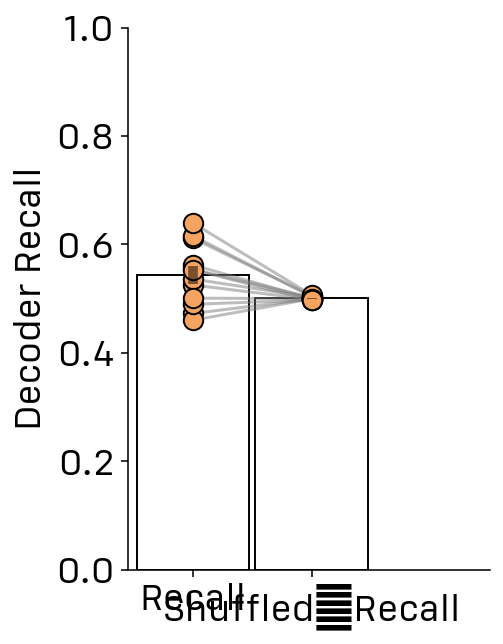

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from matplotlib.ticker import MaxNLocator

df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Recall', 'Shuffled_Recall']
means = df[conditions].mean(axis=0)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Recall'], df['Shuffled_Recall'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Recall'], row['Shuffled_Recall']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder Recall')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMtoSAM_Recall.pdf', format='pdf')
plt.show()

## neuro vs astro

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3

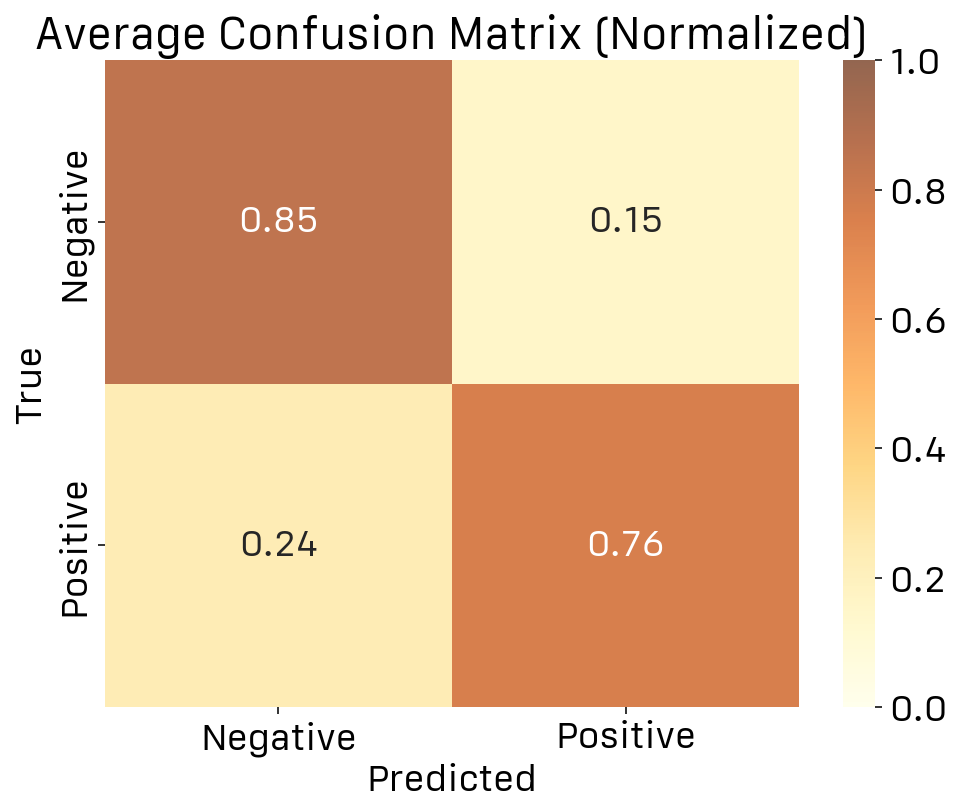

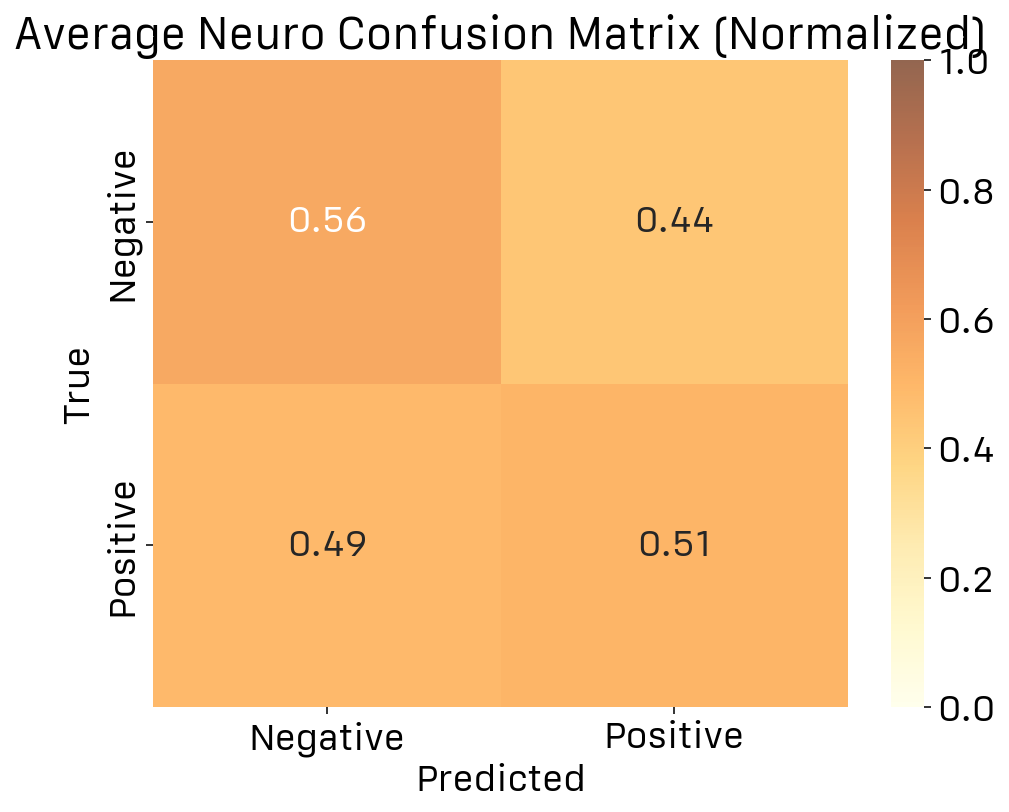

In [53]:
## One decoder per mouse, output average confusion matrix 

# Initialize results storage
confusion_matrices = []
neuro_confusion_matrices = []
results = {'ID': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], '1_f1': [], '0_f1': [], 'AUC_ROC': [],
           'Neuro_ID': [], 'Neuro_Accuracy': [], 'Neuro_Precision': [], 'Neuro_Recall': [],
           'Neuro_F1': [], 'Neuro_1_f1': [], 'Neuro_0_f1': [], 'Neuro_AUC_ROC': []}

num_repeats = 10  # number of under-sampling repeats

for efile, sfile in zip(epm_files, sam_files):
    epm = pd.read_csv(efile)
    sam = pd.read_csv(sfile)
    id = epm['ID'].iloc[0]

    # Label assignment
    epm['exploration'] = np.where(epm['In Closed Arms'] == 1, 0, 1)
    sam['exploration'] = np.where(sam['In black'] == 1, 0, 1)

    epm = epm[['Zscoreg', 'Zscorer', 'Time', 'exploration', 'ID']]
    sam = sam[['Zscoreg', 'Zscorer', 'Time', 'exploration', 'ID']]

    window_size = 300

    X_train, y_train = create_sliding_window(epm, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    X_test, y_test = create_sliding_window(sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)

    neuro_X_train, neuro_y_train = create_sliding_window(epm, signal_col='Zscorer', target_col='exploration', window_size=window_size)
    neuro_X_test, neuro_y_test = create_sliding_window(sam, signal_col='Zscorer', target_col='exploration', window_size=window_size)

    for repeat_idx in range(num_repeats):
        print(f"Repeat {repeat_idx + 1}/{num_repeats}")

        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Get best model
        best_model = grid_search.best_estimator_
        best_model.fit(X_train_resampled, y_train_resampled)
        
        # Predict probabilities for AUC-ROC calculation
        y_pred_proba = best_model.predict_proba(X_test)
        y_pred = best_model.predict(X_test)

        # Compute AUC-ROC
        auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

        # Evaluate model
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        confusion_matrices.append(cm)

        report = classification_report(y_test, y_pred, output_dict=True)
        results['ID'].append(id)
        results['Accuracy'].append(report['accuracy'])
        results['Precision'].append(report['weighted avg']['precision'])
        results['Recall'].append(report['weighted avg']['recall'])
        results['F1'].append(report['weighted avg']['f1-score'])
        results['1_f1'].append(report['1']['f1-score'])
        results['0_f1'].append(report['0']['f1-score'])
        results['AUC_ROC'].append(auc_roc)

# Neural data 

        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        neuro_X_train_resampled, neuro_y_train_resampled = undersampler.fit_resample(neuro_X_train, neuro_y_train)
        

        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(neuro_X_train_resampled, neuro_y_train_resampled)

        # Get best model
        neuro_best_model = grid_search.best_estimator_
        neuro_best_model.fit(neuro_X_train_resampled, neuro_y_train_resampled)
        
        # Predict probabilities for AUC-ROC calculation
        neuro_y_pred_proba = neuro_best_model.predict_proba(neuro_X_test)
        neuro_y_pred = neuro_best_model.predict(neuro_X_test)

        # Compute AUC-ROC
        neuro_auc_roc = roc_auc_score(neuro_y_test, neuro_y_pred_proba[:, 1])

        # Evaluate model
        neuro_cm = confusion_matrix(neuro_y_test, neuro_y_pred, normalize='true')
        neuro_confusion_matrices.append(neuro_cm)

        neuro_report = classification_report(neuro_y_test, neuro_y_pred, output_dict=True)
        results['Neuro_ID'].append(id)
        results['Neuro_Accuracy'].append(neuro_report['accuracy'])
        results['Neuro_Precision'].append(neuro_report['weighted avg']['precision'])
        results['Neuro_Recall'].append(neuro_report['weighted avg']['recall'])
        results['Neuro_F1'].append(neuro_report['weighted avg']['f1-score'])
        results['Neuro_1_f1'].append(neuro_report['1']['f1-score'])
        results['Neuro_0_f1'].append(neuro_report['0']['f1-score'])
        results['Neuro_AUC_ROC'].append(neuro_auc_roc)

# Average confusion matrices
average_cm = np.mean(confusion_matrices, axis=0)
neuro_average_cm = np.mean(neuro_confusion_matrices, axis=0)

# Calculate average results for each ID
average_results = pd.DataFrame(results).groupby('ID').mean()
print(average_results)

# Plot confusion matrices
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (Normalized)')
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jRGECOEPMtoSAM_CM.pdf', format='pdf')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(neuro_average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Neuro Confusion Matrix (Normalized)')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   0.816458   0.818405  0.816458  0.803119  0.627386  0.877848  0.879779   
64   0.785838   0.813509  0.785838  0.773352  0.688891  0.836578  0.911991   
65   0.842308   0.866709  0.842308  0.833879  0.764086  0.881502  0.943673   
66   0.685062   0.831552  0.685062  0.716341  0.521391  0.765311  0.851956   
67   0.816480   0.830467  0.816480  0.819383  0.766463  0.848844  0.889208   
68   0.940361   0.940390  0.940361  0.940056  0.773136  0.965652  0.968289   
70   0.776177   0.881957  0.776177  0.814340  0.298907  0.864905  0.773911   
71   0.761919   0.908915  0.761919  0.800736  0.499610  0.843754  0.923595   
84   0.878224   0.942884  0.878224  0.894537  0.698501  0.923082  0.998540   
150  0.757627   0.853826  0.757627  0.778466  0.609761  0.824224  0.843362   
151  0.849151   0.863107  0.849151  0.852048  0.794080  0.880945

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_27946/2244176910.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_27946/2244176910.py:27: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/EPMtoSAM_Neuro_Astro_Accuracy.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


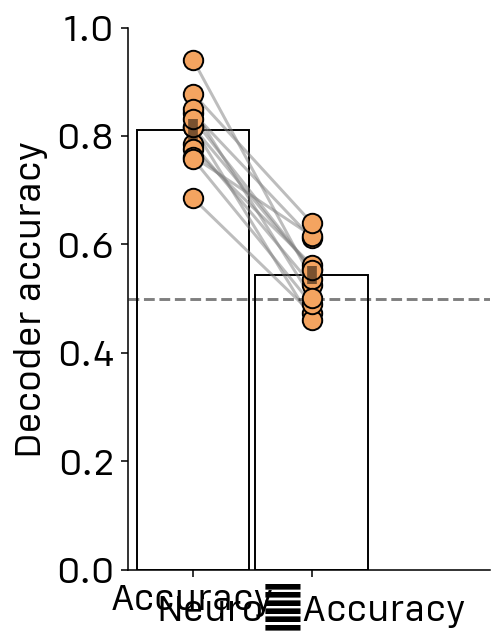

In [43]:

df = average_results.copy()
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Accuracy', 'Neuro_Accuracy']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Accuracy'], df['Neuro_Accuracy'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Accuracy'], row['Neuro_Accuracy']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder accuracy')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/EPMtoSAM_Neuro_Astro_Accuracy.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   0.816458   0.818405  0.816458  0.803119  0.627386  0.877848  0.879779   
64   0.785838   0.813509  0.785838  0.773352  0.688891  0.836578  0.911991   
65   0.842308   0.866709  0.842308  0.833879  0.764086  0.881502  0.943673   
66   0.685062   0.831552  0.685062  0.716341  0.521391  0.765311  0.851956   
67   0.816480   0.830467  0.816480  0.819383  0.766463  0.848844  0.889208   
68   0.940361   0.940390  0.940361  0.940056  0.773136  0.965652  0.968289   
70   0.776177   0.881957  0.776177  0.814340  0.298907  0.864905  0.773911   
71   0.761919   0.908915  0.761919  0.800736  0.499610  0.843754  0.923595   
84   0.878224   0.942884  0.878224  0.894537  0.698501  0.923082  0.998540   
150  0.757627   0.853826  0.757627  0.778466  0.609761  0.824224  0.843362   
151  0.849151   0.863107  0.849151  0.852048  0.794080  0.880945

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_27946/3179081095.py:27: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_27946/3179081095.py:28: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/EPMtoSAM_Neuro_Astro_AUCROC.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


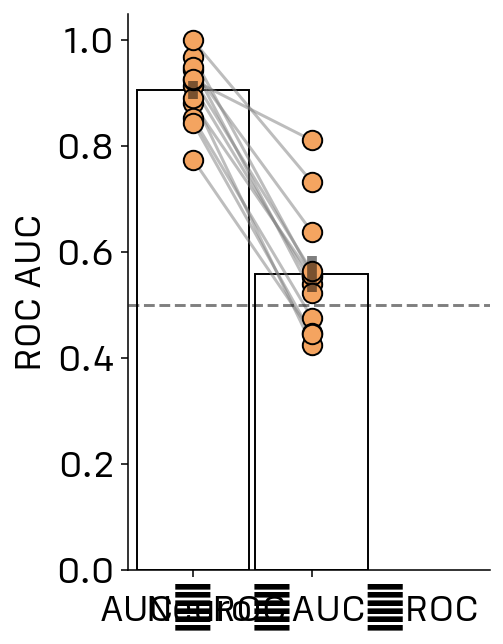

In [44]:
## ROC AUC
df = average_results.copy()
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['AUC_ROC', 'Neuro_AUC_ROC']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['AUC_ROC'], df['Neuro_AUC_ROC'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['AUC_ROC'], row['Neuro_AUC_ROC']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('ROC AUC')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/EPMtoSAM_Neuro_Astro_AUCROC.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   0.816458   0.818405  0.816458  0.803119  0.627386  0.877848  0.879779   
64   0.785838   0.813509  0.785838  0.773352  0.688891  0.836578  0.911991   
65   0.842308   0.866709  0.842308  0.833879  0.764086  0.881502  0.943673   
66   0.685062   0.831552  0.685062  0.716341  0.521391  0.765311  0.851956   
67   0.816480   0.830467  0.816480  0.819383  0.766463  0.848844  0.889208   
68   0.940361   0.940390  0.940361  0.940056  0.773136  0.965652  0.968289   
70   0.776177   0.881957  0.776177  0.814340  0.298907  0.864905  0.773911   
71   0.761919   0.908915  0.761919  0.800736  0.499610  0.843754  0.923595   
84   0.878224   0.942884  0.878224  0.894537  0.698501  0.923082  0.998540   
150  0.757627   0.853826  0.757627  0.778466  0.609761  0.824224  0.843362   
151  0.849151   0.863107  0.849151  0.852048  0.794080  0.880945

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_27946/1149764906.py:27: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_27946/1149764906.py:28: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/EPMtoSAM_Neuro_Astro_F1score.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


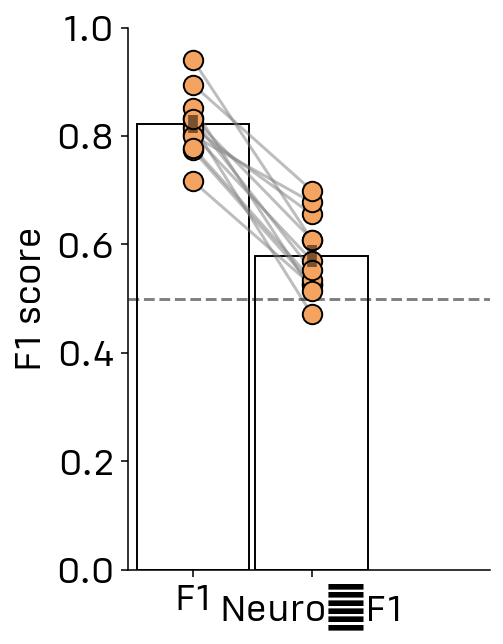

In [45]:
##  F1 score
df = average_results.copy()
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['F1', 'Neuro_F1']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['F1'], df['Neuro_F1'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['F1'], row['Neuro_F1']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('F1 score')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/EPMtoSAM_Neuro_Astro_F1score.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   0.816458   0.818405  0.816458  0.803119  0.627386  0.877848  0.879779   
64   0.785838   0.813509  0.785838  0.773352  0.688891  0.836578  0.911991   
65   0.842308   0.866709  0.842308  0.833879  0.764086  0.881502  0.943673   
66   0.685062   0.831552  0.685062  0.716341  0.521391  0.765311  0.851956   
67   0.816480   0.830467  0.816480  0.819383  0.766463  0.848844  0.889208   
68   0.940361   0.940390  0.940361  0.940056  0.773136  0.965652  0.968289   
70   0.776177   0.881957  0.776177  0.814340  0.298907  0.864905  0.773911   
71   0.761919   0.908915  0.761919  0.800736  0.499610  0.843754  0.923595   
84   0.878224   0.942884  0.878224  0.894537  0.698501  0.923082  0.998540   
150  0.757627   0.853826  0.757627  0.778466  0.609761  0.824224  0.843362   
151  0.849151   0.863107  0.849151  0.852048  0.794080  0.880945

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_27946/3961424754.py:27: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_27946/3961424754.py:28: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/EPMtoSAm_Neuro_Astro_Recall.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


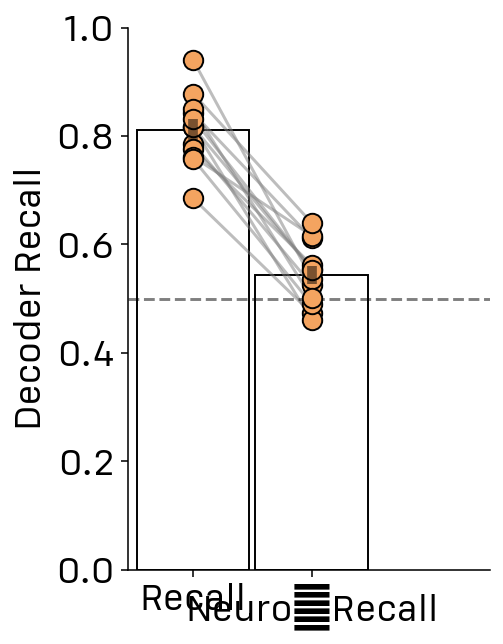

In [46]:
##  F1 score
df = average_results.copy()
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Recall', 'Neuro_Recall']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Recall'], df['Neuro_Recall'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Recall'], row['Neuro_Recall']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder Recall')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/EPMtoSAm_Neuro_Astro_Recall.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   0.816458   0.818405  0.816458  0.803119  0.627386  0.877848  0.879779   
64   0.785838   0.813509  0.785838  0.773352  0.688891  0.836578  0.911991   
65   0.842308   0.866709  0.842308  0.833879  0.764086  0.881502  0.943673   
66   0.685062   0.831552  0.685062  0.716341  0.521391  0.765311  0.851956   
67   0.816480   0.830467  0.816480  0.819383  0.766463  0.848844  0.889208   
68   0.940361   0.940390  0.940361  0.940056  0.773136  0.965652  0.968289   
70   0.776177   0.881957  0.776177  0.814340  0.298907  0.864905  0.773911   
71   0.761919   0.908915  0.761919  0.800736  0.499610  0.843754  0.923595   
84   0.878224   0.942884  0.878224  0.894537  0.698501  0.923082  0.998540   
150  0.757627   0.853826  0.757627  0.778466  0.609761  0.824224  0.843362   
151  0.849151   0.863107  0.849151  0.852048  0.794080  0.880945

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_27946/1264122482.py:27: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_27946/1264122482.py:28: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/EPMtoSAM_Neuro_Astro_Precision.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


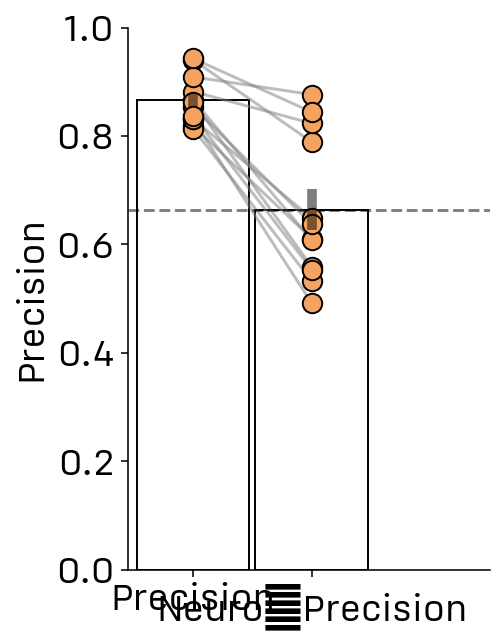

In [50]:
##  F1 score
df = average_results.copy()
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Precision', 'Neuro_Precision']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Precision'], df['Neuro_Precision'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Precision'], row['Neuro_Precision']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Precision')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.axhline(y=means['Neuro_Precision'], color='black', linestyle='--', alpha=0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/EPMtoSAM_Neuro_Astro_Precision.pdf', format='pdf')
plt.show()

r value : 0.4039699374997658, pvalue : 0.1927899953205783, r squared : 0.16319171040356467


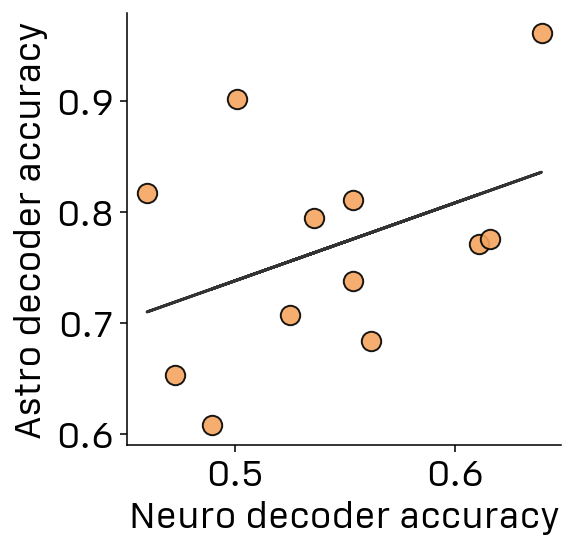

In [14]:
## correlation between neuro and astro decoder accuracy

slope, intercept, r_value, p_value, std_err = linregress(df['Neuro_Accuracy'], df['Accuracy'])

plt.figure(figsize=(4, 4))

# Corrected the x and y for the line plot
plt.plot(df['Neuro_Accuracy'], intercept + slope * df['Neuro_Accuracy'], color='black', alpha=0.8, zorder=0)
plt.scatter(df['Neuro_Accuracy'], df['Accuracy'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)

print(f'r value : {r_value}, pvalue : {p_value}, r squared : {r_value**2}')
plt.xlabel('Neuro decoder accuracy')
plt.ylabel('Astro decoder accuracy')

plt.show()

## ROC CURVE ASTRO VS NEURO

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3

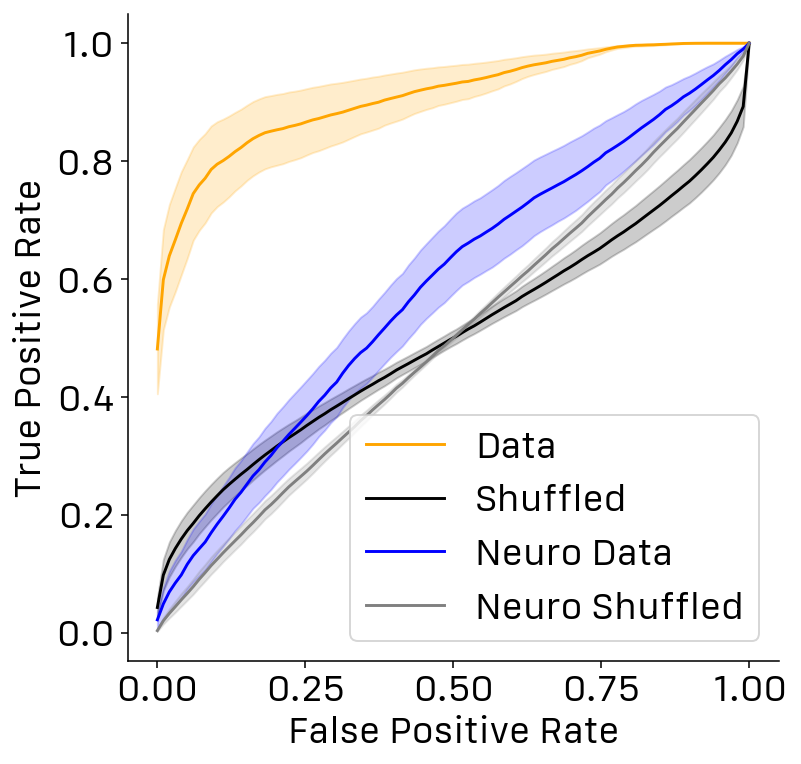

In [18]:
# Initialize results storage

roc_data = {}  # Store per-mouse ROC data
shuffled_roc_data = {}  # Store per-mouse shuffled ROC data
neuro_roc_data = {}  # Store per-mouse ROC data for neural data
shuffled_neuro_roc_data = {}  # Store per-mouse shuffled ROC data for neural data

num_repeats = 10  # number of under-sampling repeats

for efile, sfile in zip(epm_files, sam_files):
    epm = pd.read_csv(efile)
    sam = pd.read_csv(sfile)
    id = epm['ID'].iloc[0]

    # Label assignment
    epm['exploration'] = np.where(epm['In Closed Arms'] == 1, 0, 1)
    sam['exploration'] = np.where(sam['In black'] == 1, 0, 1)

    epm = epm[['Zscoreg', 'Zscorer', 'Time', 'exploration', 'ID']]
    sam = sam[['Zscoreg', 'Zscorer', 'Time', 'exploration', 'ID']]

    window_size = 300

    X_train, y_train = create_sliding_window(sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    X_test, y_test = create_sliding_window(epm, signal_col='Zscoreg', target_col='exploration', window_size=window_size)

    neuro_X_train, neuro_y_train = create_sliding_window(sam, signal_col='Zscorer', target_col='exploration', window_size=window_size)
    neuro_X_test, neuro_y_test = create_sliding_window(epm, signal_col='Zscorer', target_col='exploration', window_size=window_size)

    mouse_roc_curves = []  # Store ROC curves for each repeat
    shuffled_roc_curves = []  # Store shuffled ROC curves for each repeat

    neuro_mouse_roc_curves = []  # Store ROC curves for neural data
    shuffled_neuro_roc_curves = []  # Store shuffled ROC curves for neural data


    for repeat_idx in range(num_repeats):
        print(f"Repeat {repeat_idx + 1}/{num_repeats}")

        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Get best model
        best_model = grid_search.best_estimator_
        best_model.fit(X_train_resampled, y_train_resampled)
        
        # Predict probabilities for AUC-ROC calculation
        y_pred_proba = best_model.predict_proba(X_test)
        y_pred = best_model.predict(X_test)

        # Compute AUC-ROC
        auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

        # Compute ROC curve and store it
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
        mouse_roc_curves.append((fpr, tpr))

        # Shuffle and evaluate
        num_permutations = 50
        shuffled_ind_roc_curves = []

        for i in range(num_permutations):
            np.random.seed(42 + i)
            np.random.shuffle(y_train_resampled)

            best_model.fit(X_train_resampled, y_train_resampled)
            y_pred_shuffled_proba = best_model.predict_proba(X_test)
            y_pred_shuffled = best_model.predict(X_test)

            shuffled_auc_roc = roc_auc_score(y_test, y_pred_shuffled_proba[:, 1])

            # Compute ROC curve and store it
            shuffled_ind_fpr, shuffled_ind_tpr, _ = roc_curve(y_test, y_pred_shuffled_proba[:, 1])
            shuffled_ind_roc_curves.append((shuffled_ind_fpr, shuffled_ind_tpr))

        ####### NEURO PART #####


        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        neuro_X_train_resampled, neuro_y_train_resampled = undersampler.fit_resample(neuro_X_train, neuro_y_train)

        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(neuro_X_train_resampled, neuro_y_train_resampled)

        # Get best model
        neuro_best_model = grid_search.best_estimator_
        neuro_best_model.fit(neuro_X_train_resampled, neuro_y_train_resampled)
        
        # Predict probabilities for AUC-ROC calculation
        neuro_y_pred_proba = neuro_best_model.predict_proba(neuro_X_test)
        neuro_y_pred = neuro_best_model.predict(neuro_X_test)

        # Compute AUC-ROC
        neuro_auc_roc = roc_auc_score(neuro_y_test, neuro_y_pred_proba[:, 1])

        # Compute ROC curve and store it
        neuro_fpr, neuro_tpr, _ = roc_curve(neuro_y_test, neuro_y_pred_proba[:, 1])
        neuro_mouse_roc_curves.append((neuro_fpr, neuro_tpr))

        # Shuffle and evaluate
        num_permutations = 50
        shuffled_neuro_ind_roc_curves = []

        for i in range(num_permutations):
            np.random.seed(42 + i)
            np.random.shuffle(neuro_y_train_resampled)

            neuro_best_model.fit(neuro_X_train_resampled, neuro_y_train_resampled)
            neuro_y_pred_shuffled_proba = neuro_best_model.predict_proba(neuro_X_test)
            neuro_y_pred_shuffled = neuro_best_model.predict(neuro_X_test)

            shuffled_neuro_auc_roc = roc_auc_score(neuro_y_test, neuro_y_pred_shuffled_proba[:, 1])

            # Compute ROC curve and store it
            shuffled_neuro_ind_fpr, shuffled_neuro_ind_tpr, _ = roc_curve(neuro_y_test, neuro_y_pred_shuffled_proba[:, 1])
            shuffled_neuro_ind_roc_curves.append((shuffled_neuro_ind_fpr, shuffled_neuro_ind_tpr))

        

    # Compute per-mouse average ROC
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    shuffled_trps = []
    neuro_tprs = []
    shuffled_neuro_tprs = []

    for shuffled_fpr, shuffled_tpr in shuffled_ind_roc_curves:
        interp_tpr = np.interp(mean_fpr, shuffled_fpr, shuffled_tpr)
        shuffled_trps.append(interp_tpr)

    for fpr, tpr in mouse_roc_curves:
        interp_tpr = np.interp(mean_fpr, fpr, tpr)  # Interpolate TPR values
        tprs.append(interp_tpr)

    for shuffled_neuro_fpr, shuffled_neuro_tpr in shuffled_neuro_ind_roc_curves:
        interp_neuro_tpr = np.interp(mean_fpr, shuffled_neuro_fpr, shuffled_neuro_tpr)
        shuffled_neuro_tprs.append(interp_neuro_tpr)

    for neuro_fpr, neuro_tpr in neuro_mouse_roc_curves:
        interp_neuro_tpr = np.interp(mean_fpr, neuro_fpr, neuro_tpr)
        neuro_tprs.append(interp_neuro_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_shuffled_tpr = np.mean(shuffled_trps, axis=0)
    std_tpr = np.std(tprs, axis=0)
    shuffled_std_tpr = np.std(shuffled_trps, axis=0)

    mean_neuro_tpr = np.mean(neuro_tprs, axis=0)
    mean_shuffled_neuro_tpr = np.mean(shuffled_neuro_tprs, axis=0)
    std_neuro_tpr = np.std(neuro_tprs, axis=0)
    shuffled_std_neuro_tpr = np.std(shuffled_neuro_tprs, axis=0)

    # plt.plot(mean_fpr, mean_tpr, color='orange', alpha=0.2)  
    # plt.plot(mean_fpr, mean_shuffled_tpr, color='black', alpha=0.2)

    roc_data[id] = (mean_fpr, mean_tpr, std_tpr)
    shuffled_roc_data[id] = (mean_fpr, mean_shuffled_tpr, shuffled_std_tpr)
    neuro_roc_data[id] = (mean_fpr, mean_neuro_tpr, std_neuro_tpr)
    shuffled_neuro_roc_data[id] = (mean_fpr, mean_shuffled_neuro_tpr, shuffled_std_neuro_tpr)



# Compute overall mean ROC curve across mice
all_mean_tprs = []
shuffled_all_mean_tprs = []
all_mean_fprs = np.linspace(0, 1, 100)

neuro_all_mean_tprs = []
shuffled_neuro_all_mean_tprs = []


for mouse_id in shuffled_roc_data:
    shuffled_all_mean_tprs.append(np.interp(all_mean_fprs, shuffled_roc_data[mouse_id][0], shuffled_roc_data[mouse_id][1]))

shuffled_final_mean_tpr = np.mean(shuffled_all_mean_tprs, axis=0)
shuffled_final_sem_tpr = np.std(shuffled_all_mean_tprs, axis=0) / np.sqrt(len(shuffled_all_mean_tprs))

for mouse_id in roc_data:
    all_mean_tprs.append(np.interp(all_mean_fprs, roc_data[mouse_id][0], roc_data[mouse_id][1]))

final_mean_tpr = np.mean(all_mean_tprs, axis=0)
final_sem_tpr = np.std(all_mean_tprs, axis=0) / np.sqrt(len(all_mean_tprs))

for mouse_id in neuro_roc_data:
    neuro_all_mean_tprs.append(np.interp(all_mean_fprs, neuro_roc_data[mouse_id][0], neuro_roc_data[mouse_id][1]))
final_neuro_mean_tpr = np.mean(neuro_all_mean_tprs, axis=0)
final_neuro_sem_tpr = np.std(neuro_all_mean_tprs, axis=0) / np.sqrt(len(neuro_all_mean_tprs))

for mouse_id in shuffled_neuro_roc_data:
    shuffled_neuro_all_mean_tprs.append(np.interp(all_mean_fprs, shuffled_neuro_roc_data[mouse_id][0], shuffled_neuro_roc_data[mouse_id][1]))
shuffled_final_neuro_mean_tpr = np.mean(shuffled_neuro_all_mean_tprs, axis=0)
shuffled_final_neuro_sem_tpr = np.std(shuffled_neuro_all_mean_tprs, axis=0) / np.sqrt(len(shuffled_neuro_all_mean_tprs))


# Plot mean ROC curve with standard deviation

plt.figure(figsize=(6, 6))
plt.plot(all_mean_fprs, final_mean_tpr, color='orange', label='Data')
plt.plot(all_mean_fprs, shuffled_final_mean_tpr, color='black', label='Shuffled')
plt.fill_between(all_mean_fprs, final_mean_tpr - final_sem_tpr, final_mean_tpr + final_sem_tpr, color='orange', alpha=0.2)
plt.fill_between(all_mean_fprs, shuffled_final_mean_tpr - shuffled_final_sem_tpr, shuffled_final_mean_tpr + shuffled_final_sem_tpr, color='black', alpha=0.2)

plt.plot(all_mean_fprs, final_neuro_mean_tpr, color='blue', label='Neuro Data')
plt.plot(all_mean_fprs, shuffled_final_neuro_mean_tpr, color='gray', label='Neuro Shuffled')
plt.fill_between(all_mean_fprs, final_neuro_mean_tpr - final_neuro_sem_tpr, final_neuro_mean_tpr + final_neuro_sem_tpr, color='blue', alpha=0.2)
plt.fill_between(all_mean_fprs, shuffled_final_neuro_mean_tpr - shuffled_final_neuro_sem_tpr, shuffled_final_neuro_mean_tpr + shuffled_final_neuro_sem_tpr, color='gray', alpha=0.2)

# plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.6)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()










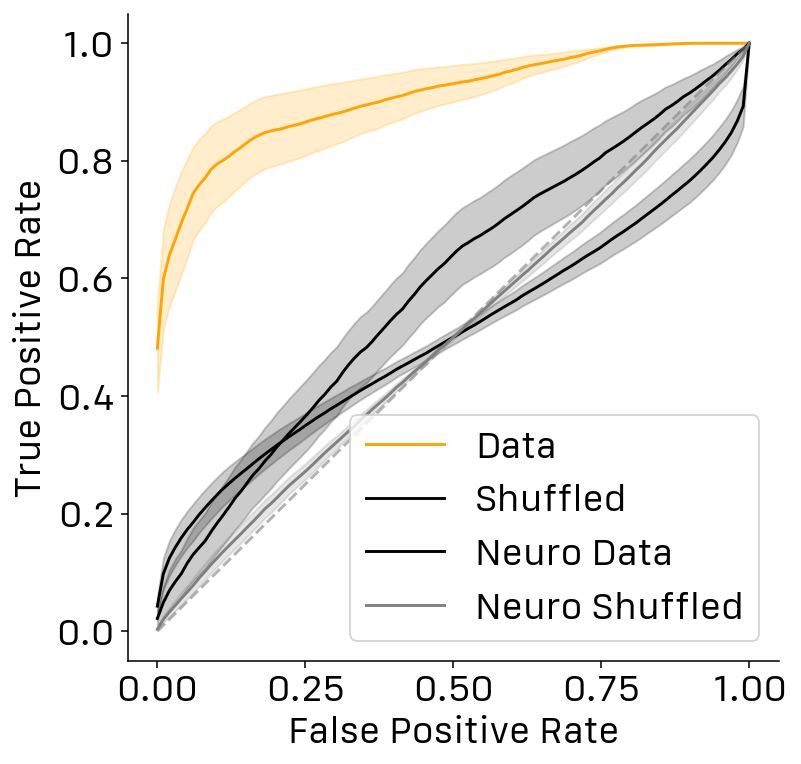

In [19]:
plt.figure(figsize=(6, 6))
plt.plot(all_mean_fprs, final_mean_tpr, color='orange', label='Data')
plt.plot(all_mean_fprs, shuffled_final_mean_tpr, color='black', label='Shuffled')
plt.fill_between(all_mean_fprs, final_mean_tpr - final_sem_tpr, final_mean_tpr + final_sem_tpr, color='orange', alpha=0.2)
plt.fill_between(all_mean_fprs, shuffled_final_mean_tpr - shuffled_final_sem_tpr, shuffled_final_mean_tpr + shuffled_final_sem_tpr, color='black', alpha=0.2)

plt.plot(all_mean_fprs, final_neuro_mean_tpr, color='black', label='Neuro Data')
plt.plot(all_mean_fprs, shuffled_final_neuro_mean_tpr, color='gray', label='Neuro Shuffled')
plt.fill_between(all_mean_fprs, final_neuro_mean_tpr - final_neuro_sem_tpr, final_neuro_mean_tpr + final_neuro_sem_tpr, color='black', alpha=0.2)
plt.fill_between(all_mean_fprs, shuffled_final_neuro_mean_tpr - shuffled_final_neuro_sem_tpr, shuffled_final_neuro_mean_tpr + shuffled_final_neuro_sem_tpr, color='gray', alpha=0.2)

# plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.6)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.6, label='Unity Line')  # Unity line
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/Neuro_EPMtoSAM_ROC_curveC.pdf', format='pdf')
plt.show()


## EPM + SAM to Y Maze

### First explo

Repeat 1/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 7/10
Repeat 8/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 9/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 10/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 1/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 9/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 10/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 1/10
Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 4/10
Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 7/10
Repeat 8/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 9/10
Repeat 10/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 1/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10
Repeat 6/10
Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 9/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 10/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 9/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 10/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
64   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
65   0.895652   0.915051  0.895652  0.893101  0.910383  0.874247  1.000000   
66   0.637736   0.835374  0.637736  0.642111  0.649473  0.625086  0.783446   
67   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
68   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
71   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
84   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
151  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
152  1.000000   1.000

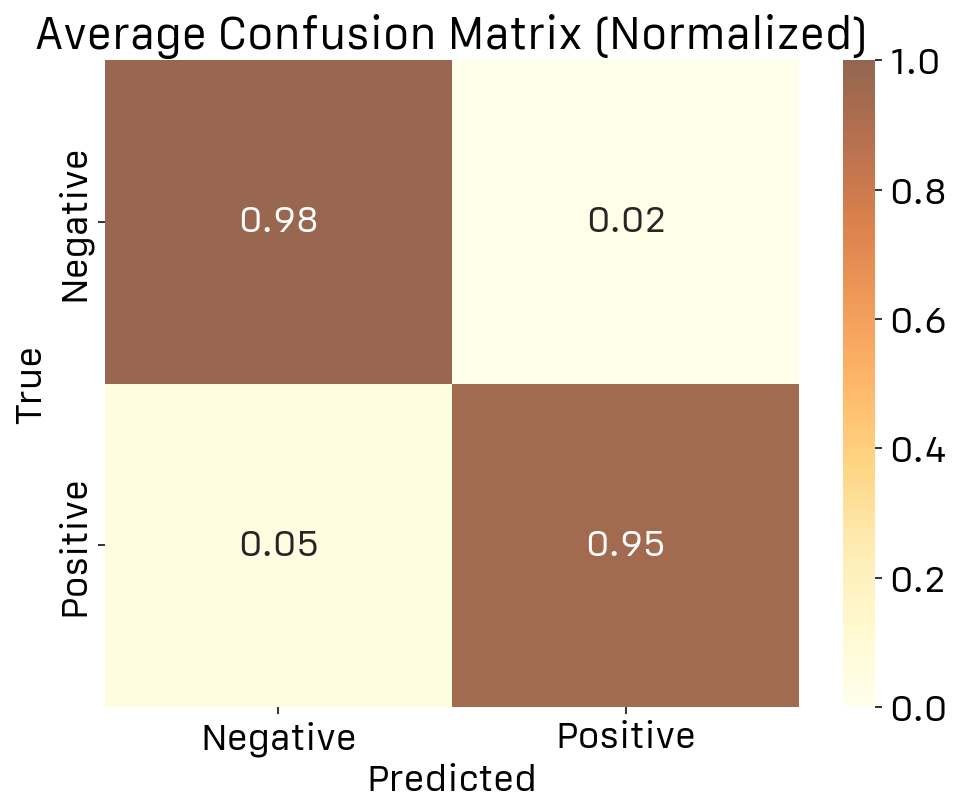

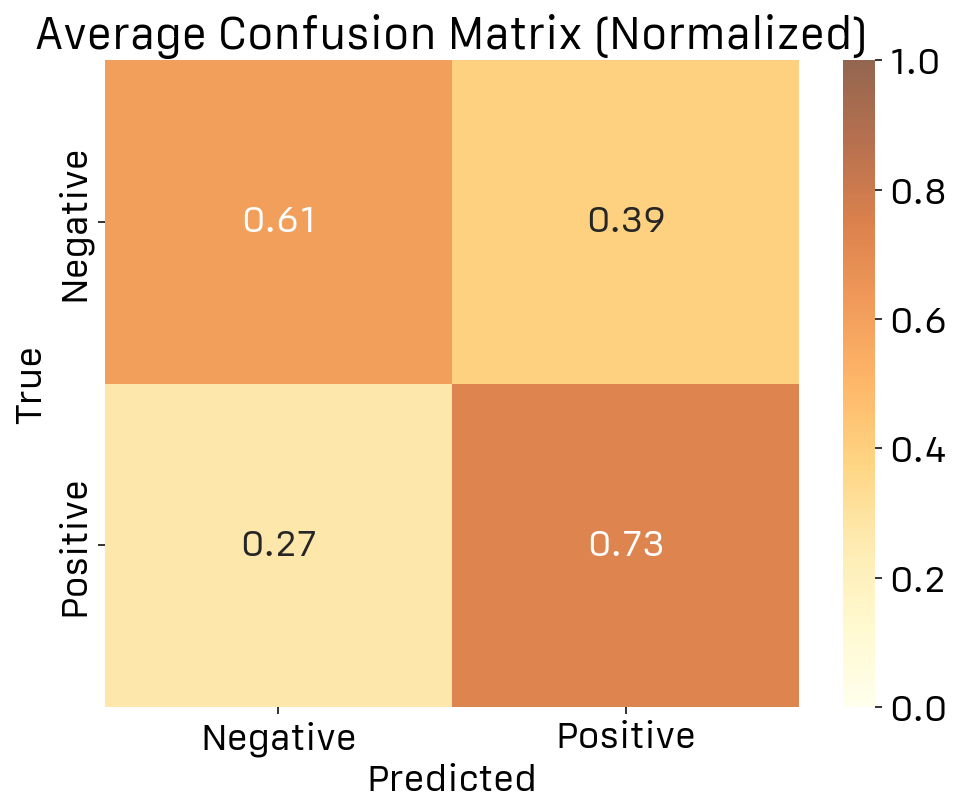

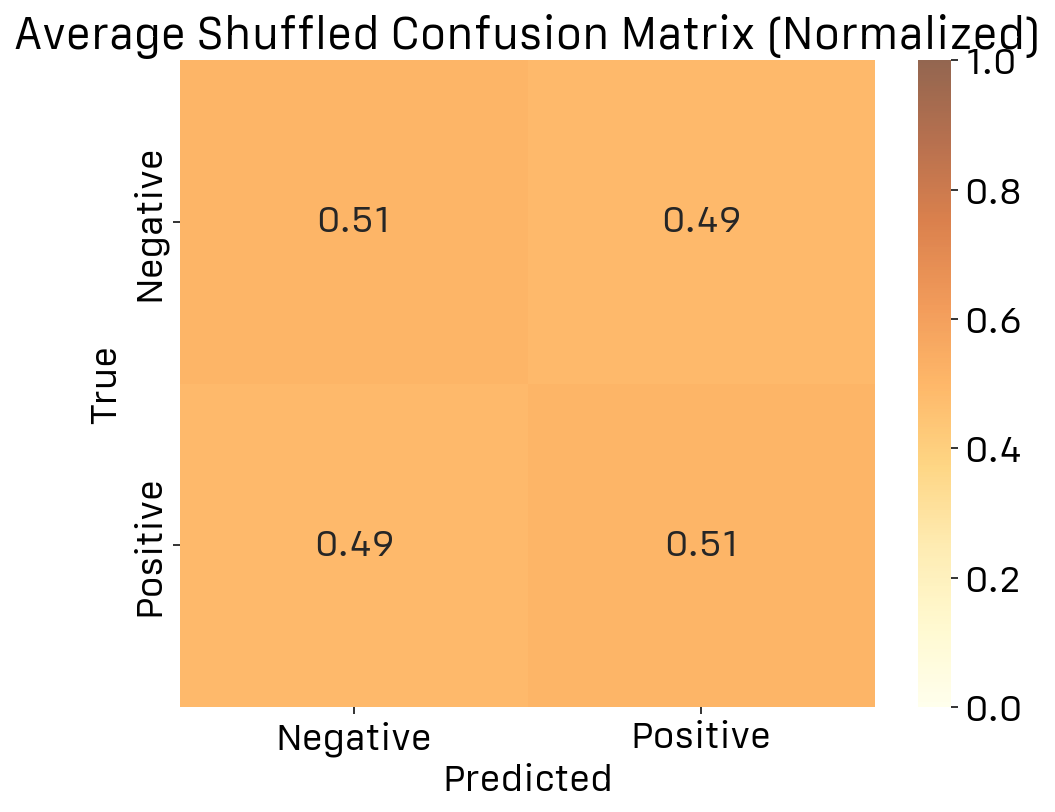

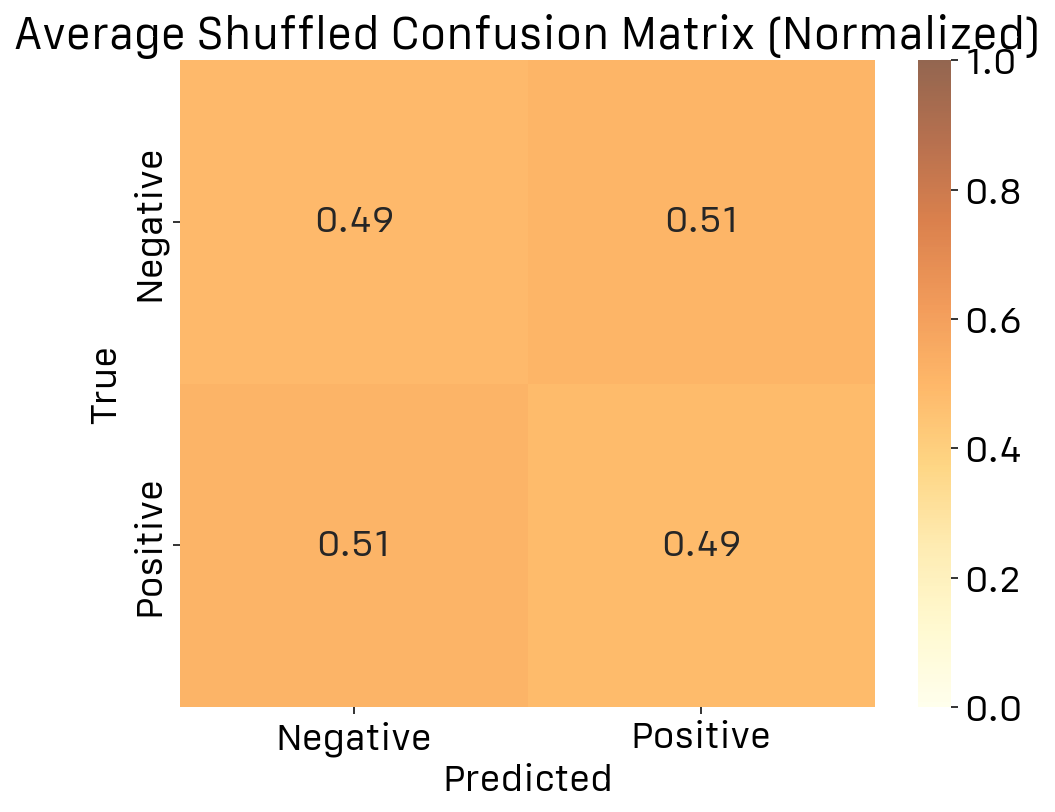

In [65]:
### DECODER FIRST EXPLO NEURO VS ASTRO 

#SAM
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/sam/preprocessed'
sam_files = glob.glob(os.path.join(directory, "*.csv"))

sam_files

#EPM 
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/epm/JrGECO_EPM/preprocessed'
epm_files = glob.glob(os.path.join(directory, "*.csv"))

epm_files


#Ymaze

directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/ymaze/preprocessed'
ymaze_files = glob.glob(os.path.join(directory, "*.csv"))

ymaze_files


# Initialize results storage
confusion_matrices = []
confusion_matrices_neuro = []
shuffled_confusion_matrices = []
shuffled_confusion_matrices_neuro = []

results = {'ID': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], '1_f1': [], '0_f1': [], 'AUC_ROC': [], 'Neuro_Accuracy': [], 
              'Neuro_Precision': [], 'Neuro_Recall': [], 'Neuro_F1': [], 'Neuro_1_f1': [], 'Neuro_0_f1': [], 'Neuro_AUC_ROC': [],
           'Shuffled_ID': [], 'Shuffled_Accuracy': [], 'Shuffled_Precision': [], 'Shuffled_Recall': [],
           'Shuffled_F1': [], 'Shuffled_1_f1': [], 'Shuffled_0_f1': [], 'Shuffled_AUC_ROC': [], 
           'Neuro_Shuffled_Accuracy': [], 'Neuro_Shuffled_Precision': [], 'Neuro_Shuffled_Recall': [],
           'Neuro_Shuffled_F1': [], 'Neuro_Shuffled_1_f1': [], 'Neuro_Shuffled_0_f1': [], 'Neuro_Shuffled_AUC_ROC': []}

num_repeats = 10  # number of under-sampling repeats


for efile, sfile, yfile in zip(epm_files, sam_files, ymaze_files):
    epm = pd.read_csv(efile)
    sam = pd.read_csv(sfile)

    ym = pd.read_csv(yfile)

    id=epm['ID'].iloc[0]

    # Preprocess epm data
    epm.loc[epm['In Closed Arms'] == 1, 'exploration'] = 0
    epm.loc[epm['In Closed Arms'] == 0, 'exploration'] = 1
    epm = epm[['Zscoreg', 'Zscorer', 'Time', 'exploration', 'ID']]

    # Preprocess sam data
    sam.loc[sam['In black'] == 1, 'exploration'] = 0
    sam.loc[sam['In black'] == 0, 'exploration'] = 1
    sam = sam[['Zscoreg', 'Zscorer', 'Time', 'exploration', 'ID']]

    # Concat epm + sam
    epm_sam = pd.concat([epm, sam], axis=0)


    # Preprocess ym data


    ym['In farm'] = 0
    ym.loc[(ym['In larm'] == 1) | (ym['In rarm'] == 1), 'In farm'] = 1


  
    explostart = ym[(ym['In Novelarm'].shift() == 0) & (ym['In Novelarm'] == 1)].index[0]
    exploend = ym[(ym['In Novelarm'].shift() == 1) & (ym['In Novelarm'] == 0)].index[0]

    ymtest = ym.loc[explostart:]

    nexplostart = ymtest[(ymtest['In farm'].shift() == 0) & (ymtest['In farm'] == 1)].index
    nexploend = ymtest[(ymtest['In farm'].shift() == 1) & (ymtest['In farm'] == 0)].index

    validnexplostart = []
    validnexploend = []

    for start, end in zip(nexplostart, nexploend):
        if end-start > 300:  ### keep only the first explo that fits the 5 seconds criterion
            validnexplostart.append(start)
            validnexploend.append(end)


    ymfirstexplo = pd.concat([ym.loc[explostart:exploend], ym.loc[validnexplostart[0]:validnexploend[0]]])


    ymfirstexplo['exploration'] = 0
    ymfirstexplo.loc[ymfirstexplo['In Novelarm'] == 1, 'exploration'] = 1

    ### dataset against other explo 

    ymotherexplo = ym.loc[validnexploend[0]:]
    ymotherexplo = ymotherexplo[(ymotherexplo['In Novelarm'] == 1) | (ymotherexplo['In farm'] == 1)]


    ymotherexplo['exploration'] = 0
    ymotherexplo.loc[ymotherexplo['In Novelarm'] == 1, 'exploration'] = 1
    ymotherexplo.loc[ymotherexplo['In farm'] == 1, 'exploration'] = 0



    # Parameters
    window_size = 300  # Sliding window size

    # Prepare training and testing datasets
    X_train, y_train = create_sliding_window(epm_sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    neuro_X_train, neuro_y_train = create_sliding_window(epm_sam, signal_col='Zscorer', target_col='exploration', window_size=window_size)
    X_testfirstexplo, y_testfirstexplo = create_sliding_window(ymfirstexplo, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    neuro_X_testfirstexplo, neuro_y_testfirstexplo = create_sliding_window(ymfirstexplo, signal_col='Zscorer', target_col='exploration', window_size=window_size)

    for repeat_idx in range(num_repeats):
        print(f"Repeat {repeat_idx + 1}/{num_repeats}")

        ## Model training ##############################

        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Get best model
        best_model = grid_search.best_estimator_
        best_model.fit(X_train_resampled, y_train_resampled)

         ## Model evaluation FIRST explo ##############################

        # Predict probabilities for AUC-ROC calculation
        y_pred_proba = best_model.predict_proba(X_testfirstexplo)

        y_pred = best_model.predict(X_testfirstexplo)

        # Compute AUC-ROC
        auc_roc = roc_auc_score(y_testfirstexplo, y_pred_proba[:, 1])

        # Evaluate model
        cm = confusion_matrix(y_testfirstexplo, y_pred, normalize='true')
        confusion_matrices.append(cm)

        report = classification_report(y_testfirstexplo, y_pred, output_dict=True)
        results['ID'].append(id)
        results['Accuracy'].append(report['accuracy'])
        results['Precision'].append(report['weighted avg']['precision'])
        results['Recall'].append(report['weighted avg']['recall'])
        results['F1'].append(report['weighted avg']['f1-score'])
        results['1_f1'].append(report['1']['f1-score'])
        results['0_f1'].append(report['0']['f1-score'])
        results['AUC_ROC'].append(auc_roc)


        # Shuffle and evaluate
        num_permutations = 50
        shuffled_cm_list = []
        shuffled_results_list = []

        for i in range(num_permutations):
            np.random.seed(42 + i)
            np.random.shuffle(y_train_resampled)

            ####### astrocytes

            best_model.fit(X_train_resampled, y_train_resampled)
            y_pred_shuffled_proba = best_model.predict_proba(X_testfirstexplo)
            y_pred_shuffled = best_model.predict(X_testfirstexplo)

            shuffled_auc_roc = roc_auc_score(y_testfirstexplo, y_pred_shuffled_proba[:, 1])

            shuffled_report = classification_report(y_testfirstexplo, y_pred_shuffled, output_dict=True)
            shuffled_results_list.append({
                'Shuffled_Accuracy': shuffled_report['accuracy'],
                'Shuffled_Precision': shuffled_report['weighted avg']['precision'],
                'Shuffled_Recall': shuffled_report['weighted avg']['recall'],
                'Shuffled_F1': shuffled_report['weighted avg']['f1-score'],
                'Shuffled_1_f1': shuffled_report['1']['f1-score'],
                'Shuffled_0_f1': shuffled_report['0']['f1-score'],
                'Shuffled_AUC_ROC': shuffled_auc_roc
            })

            cm_shuffled = confusion_matrix(y_testfirstexplo, y_pred_shuffled, normalize='true')
            shuffled_cm_list.append(cm_shuffled)


        avg_shuffled_cm = np.mean(shuffled_cm_list, axis=0)
        shuffled_average_results = {
            key: np.mean([res[key] for res in shuffled_results_list]) for key in shuffled_results_list[0]
        }
        results['Shuffled_ID'].append(id)
        results['Shuffled_Accuracy'].append(shuffled_average_results['Shuffled_Accuracy'])
        results['Shuffled_Precision'].append(shuffled_average_results['Shuffled_Precision'])
        results['Shuffled_Recall'].append(shuffled_average_results['Shuffled_Recall'])
        results['Shuffled_F1'].append(shuffled_average_results['Shuffled_F1'])
        results['Shuffled_1_f1'].append(shuffled_average_results['Shuffled_1_f1'])
        results['Shuffled_0_f1'].append(shuffled_average_results['Shuffled_0_f1'])
        results['Shuffled_AUC_ROC'].append(shuffled_average_results['Shuffled_AUC_ROC'])


        shuffled_confusion_matrices.append(avg_shuffled_cm)

        ### NEURO PART #####

        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        neuro_X_train_resampled, neuro_y_train_resampled = undersampler.fit_resample(neuro_X_train, neuro_y_train)

        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(neuro_X_train_resampled, neuro_y_train_resampled)

        # Get best model
        neuro_best_model = grid_search.best_estimator_
        neuro_best_model.fit(neuro_X_train_resampled, neuro_y_train_resampled)

        # Predict probabilities for AUC-ROC calculation
        neuro_y_pred_proba = neuro_best_model.predict_proba(neuro_X_testfirstexplo)
        neuro_y_pred = neuro_best_model.predict(neuro_X_testfirstexplo)

        # Compute AUC-ROC
        auc_roc2 = roc_auc_score(neuro_y_testfirstexplo, neuro_y_pred_proba[:, 1])

        # Evaluate model
        cm2 = confusion_matrix(neuro_y_testfirstexplo, neuro_y_pred, normalize='true')
        confusion_matrices_neuro.append(cm2)

        report = classification_report(neuro_y_testfirstexplo, neuro_y_pred, output_dict=True)
        results['Neuro_Accuracy'].append(report['accuracy'])
        results['Neuro_Precision'].append(report['weighted avg']['precision'])
        results['Neuro_Recall'].append(report['weighted avg']['recall'])
        results['Neuro_F1'].append(report['weighted avg']['f1-score'])
        results['Neuro_1_f1'].append(report['1']['f1-score'])
        results['Neuro_0_f1'].append(report['0']['f1-score'])
        results['Neuro_AUC_ROC'].append(auc_roc2)


        # Shuffle and evaluate
        num_permutations = 50
        shuffled_cm_list2 = []
        shuffled_results_list2 = []

        for i in range(num_permutations):
            np.random.seed(42 + i)
            np.random.shuffle(neuro_y_train_resampled)

            neuro_best_model.fit(neuro_X_train_resampled, neuro_y_train_resampled)
            neuro_y_pred_shuffled_proba = neuro_best_model.predict_proba(neuro_X_testfirstexplo)
            neuro_y_pred_shuffled = neuro_best_model.predict(neuro_X_testfirstexplo)

            shuffled_auc_roc2 = roc_auc_score(neuro_y_testfirstexplo, neuro_y_pred_shuffled_proba[:, 1])

            shuffled_report2 = classification_report(neuro_y_testfirstexplo, neuro_y_pred_shuffled, output_dict=True)
            
            shuffled_results_list2.append({
                'Shuffled_Accuracy2': shuffled_report2['accuracy'],
                'Shuffled_Precision2': shuffled_report2['weighted avg']['precision'],
                'Shuffled_Recall2': shuffled_report2['weighted avg']['recall'],
                'Shuffled_F12': shuffled_report2['weighted avg']['f1-score'],
                'Shuffled_1_f12': shuffled_report2['1']['f1-score'],
                'Shuffled_0_f12': shuffled_report2['0']['f1-score'],
                'Shuffled_AUC_ROC2': shuffled_auc_roc2
            })

            cm_shuffled2 = confusion_matrix(neuro_y_testfirstexplo, neuro_y_pred_shuffled, normalize='true')
            shuffled_cm_list2.append(cm_shuffled2)

        avg_shuffled_cm2 = np.mean(shuffled_cm_list2, axis=0)
        shuffled_average_results2 = {
            key: np.mean([res[key] for res in shuffled_results_list2]) for key in shuffled_results_list2[0]
        }

        results['Neuro_Shuffled_Accuracy'].append(shuffled_average_results2['Shuffled_Accuracy2'])
        results['Neuro_Shuffled_Precision'].append(shuffled_average_results2['Shuffled_Precision2'])
        results['Neuro_Shuffled_Recall'].append(shuffled_average_results2['Shuffled_Recall2'])
        results['Neuro_Shuffled_F1'].append(shuffled_average_results2['Shuffled_F12'])
        results['Neuro_Shuffled_1_f1'].append(shuffled_average_results2['Shuffled_1_f12'])
        results['Neuro_Shuffled_0_f1'].append(shuffled_average_results2['Shuffled_0_f12'])
        results['Neuro_Shuffled_AUC_ROC'].append(shuffled_average_results2['Shuffled_AUC_ROC2'])

        shuffled_confusion_matrices_neuro.append(avg_shuffled_cm2)



# Average confusion matrices
average_cm = np.mean(confusion_matrices, axis=0)
average_cm2 = np.mean(confusion_matrices_neuro, axis=0)
shuffled_average_cm = np.mean(shuffled_confusion_matrices, axis=0)
shuffled_average_cm2 = np.mean(shuffled_confusion_matrices_neuro, axis=0)

# Calculate average results for each ID
average_results = pd.DataFrame(results).groupby('ID').mean()
print(average_results)

# Plot confusion matrices

#### DATA FIRST EXPLO
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (Normalized)')
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_firstexplo.pdf', format='pdf')
plt.show()


### DATA NEURO EXPLO
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm2, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (Normalized)')
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_otherexplo.pdf', format='pdf')
plt.show()

### SHUFFLED FIRST EXPLO
plt.figure(figsize=(8, 6))
sns.heatmap(shuffled_average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Shuffled Confusion Matrix (Normalized)')
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_firstexploSHUFFLED.pdf', format='pdf')
plt.show()

### SHUFFLED NEURO FIRST EXPLO

plt.figure(figsize=(8, 6))
sns.heatmap(shuffled_average_cm2, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Shuffled Confusion Matrix (Normalized)')
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_otherexploSHUFFLED.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
64   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
65   0.895652   0.915051  0.895652  0.893101  0.910383  0.874247  1.000000   
66   0.637736   0.835374  0.637736  0.642111  0.649473  0.625086  0.783446   
67   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
68   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
71   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
84   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
151  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
152  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

     Neuro_Accuracy  Neuro_Precision  Neuro_Recall  ...  Shuffl

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/8865196.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/8865196.py:27: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeFIRST_Accuracy.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


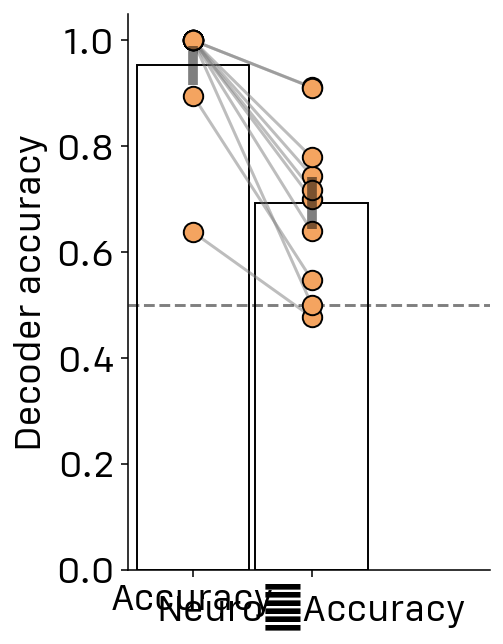

In [33]:
df = pd.DataFrame(average_results)
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Accuracy', 'Neuro_Accuracy']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Accuracy'], df['Neuro_Accuracy'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Accuracy'], row['Neuro_Accuracy']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder accuracy')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeFIRST_Accuracy.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
64   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
65   0.895652   0.915051  0.895652  0.893101  0.910383  0.874247  1.000000   
66   0.637736   0.835374  0.637736  0.642111  0.649473  0.625086  0.783446   
67   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
68   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
71   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
84   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
151  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
152  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

     Neuro_Accuracy  Neuro_Precision  Neuro_Recall  ...  Shuffl

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/3380271964.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/3380271964.py:27: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeFIRST_F1.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


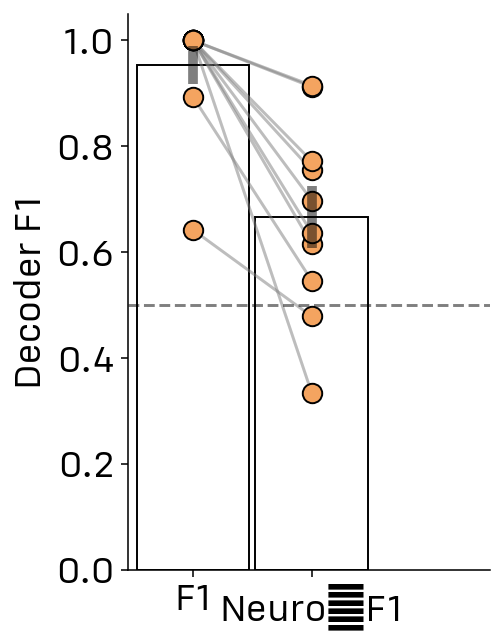

In [49]:
df = pd.DataFrame(average_results)
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['F1', 'Neuro_F1']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['F1'], df['Neuro_F1'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['F1'], row['Neuro_F1']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder F1')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeFIRST_F1.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
64   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
65   0.895652   0.915051  0.895652  0.893101  0.910383  0.874247  1.000000   
66   0.637736   0.835374  0.637736  0.642111  0.649473  0.625086  0.783446   
67   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
68   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
71   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
84   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
151  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
152  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

     Neuro_Accuracy  Neuro_Precision  Neuro_Recall  ...  Shuffl

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/3513212874.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/3513212874.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeFIRST_precision.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


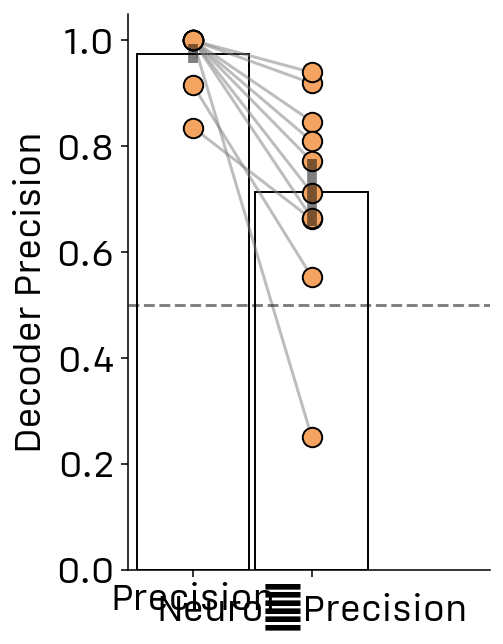

In [50]:
df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4, 5))
conditions = ['Precision', 'Neuro_Precision']
means = df[conditions].mean(axis=0)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Precision'], df['Neuro_Precision'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
    zorder=0)
for condition in conditions:
    plt.scatter([condition] * len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Precision'], row['Neuro_Precision']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder Precision')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55, 3 - 0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeFIRST_precision.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
64   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
65   0.895652   0.915051  0.895652  0.893101  0.910383  0.874247  1.000000   
66   0.637736   0.835374  0.637736  0.642111  0.649473  0.625086  0.783446   
67   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
68   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
71   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
84   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
151  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
152  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

     Neuro_Accuracy  Neuro_Precision  Neuro_Recall  ...  Shuffl

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/4033120293.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/4033120293.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeFIRST_recall.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


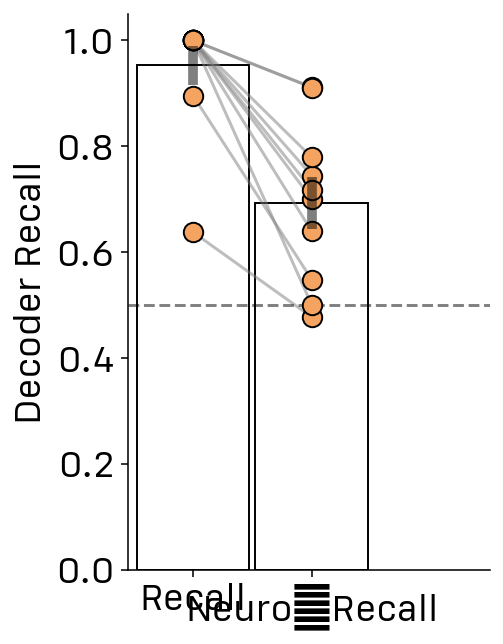

In [62]:

df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Recall', 'Neuro_Recall']
means = df[conditions].mean(axis=0)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Recall'], df['Neuro_Recall'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Recall'], row['Neuro_Recall']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder Recall')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeFIRST_recall.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
64   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
65   0.895652   0.915051  0.895652  0.893101  0.910383  0.874247  1.000000   
66   0.637736   0.835374  0.637736  0.642111  0.649473  0.625086  0.783446   
67   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
68   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
71   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
84   1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
151  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
152  1.000000   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

     Neuro_Accuracy  Neuro_Precision  Neuro_Recall  ...  Shuffl

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/450933527.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_50820/450933527.py:27: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeFIRST_AUCROC.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


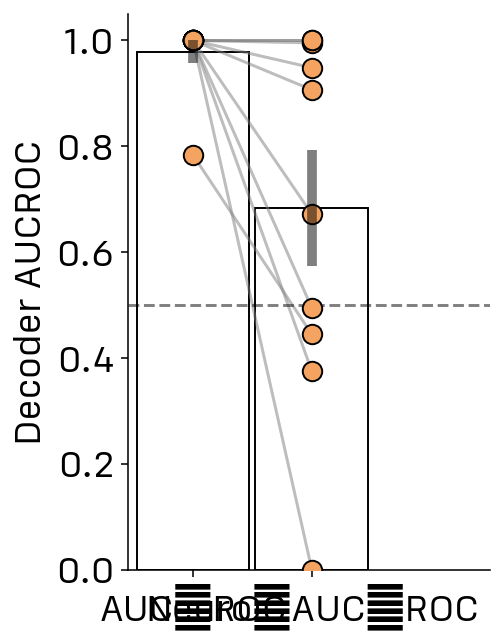

In [60]:

df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['AUC_ROC', 'Neuro_AUC_ROC']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['AUC_ROC'], df['Neuro_AUC_ROC'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['AUC_ROC'], row['Neuro_AUC_ROC']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder AUCROC')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeFIRST_AUCROC.pdf', format='pdf')
plt.show()

### other explo 

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 2/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 3/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 4/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 5/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 6/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 7/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 8/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 9/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 10/10


/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
Repeat 1/10
Repeat 2/10
Repeat 3/10
Repeat 4/10
Repeat 5/10
Repeat 6/10
Repeat 7/10
Repeat 8/10
Repeat 9/10
Repeat 10/10
     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                         

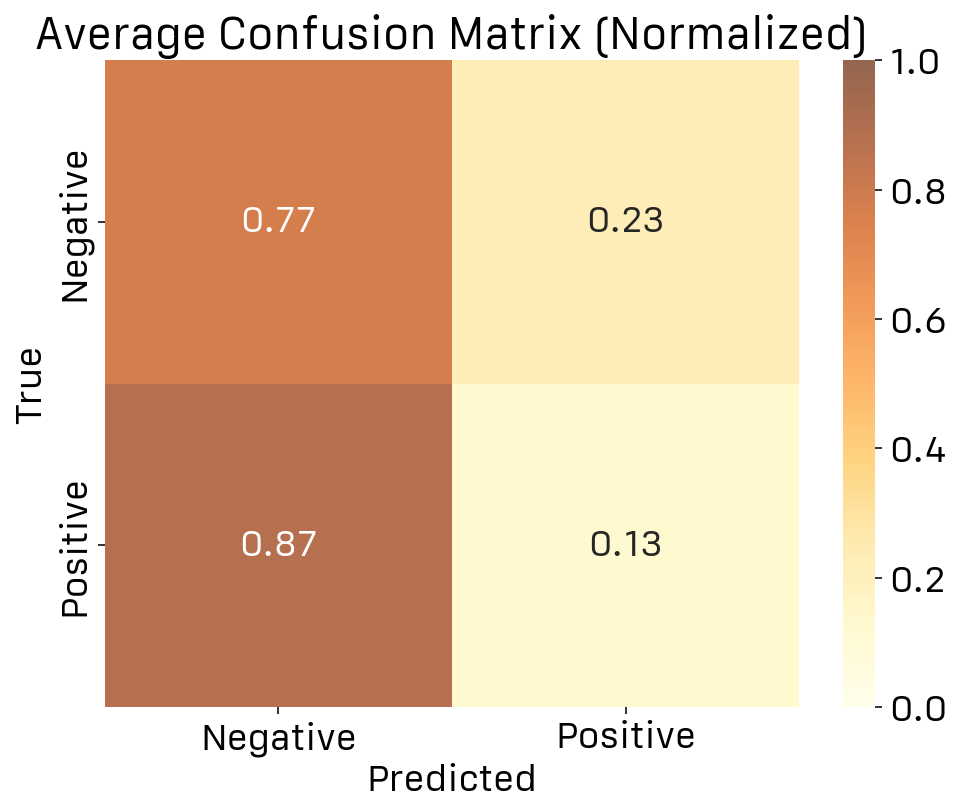

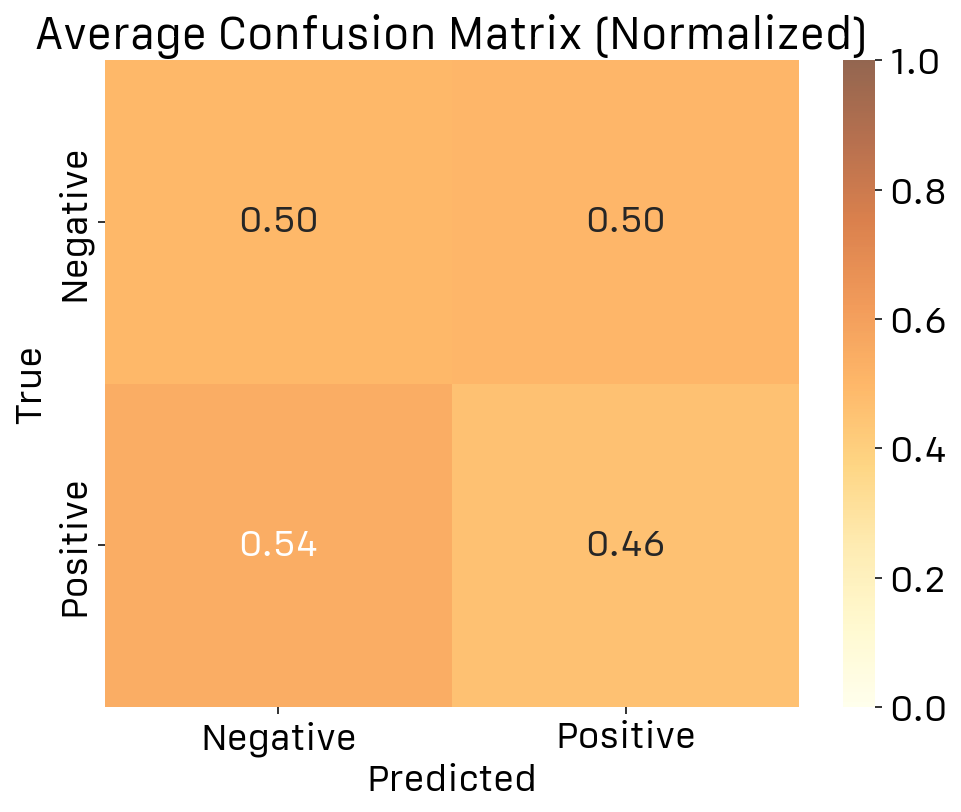

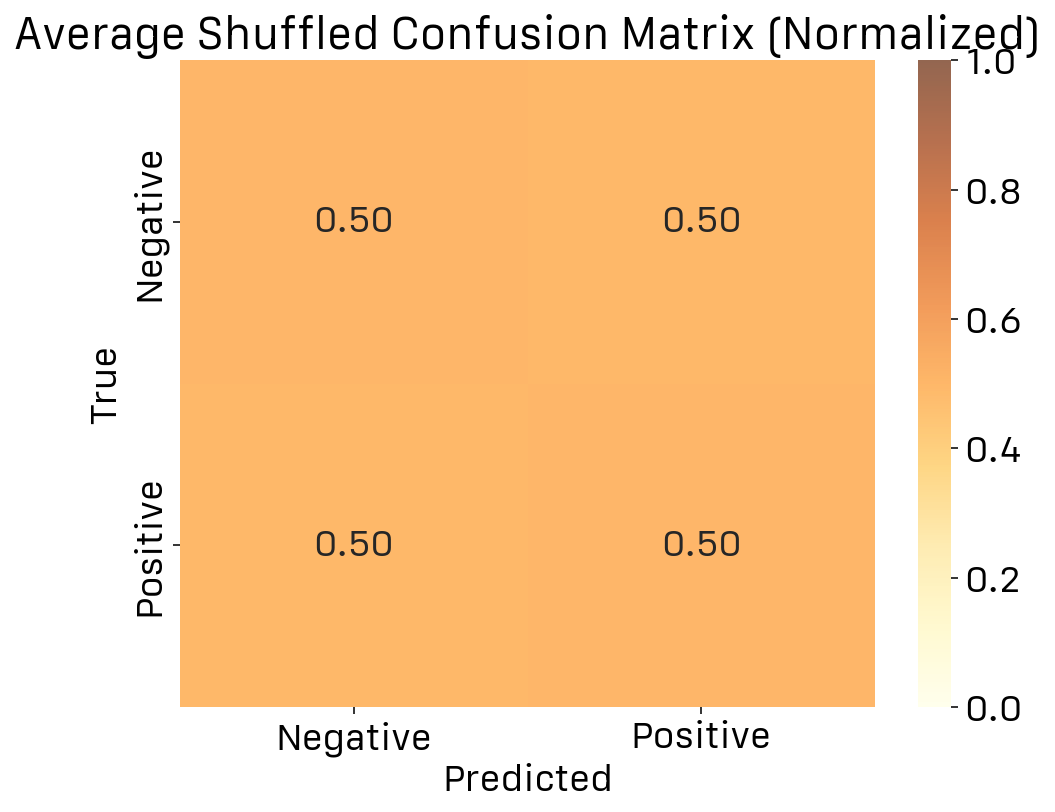

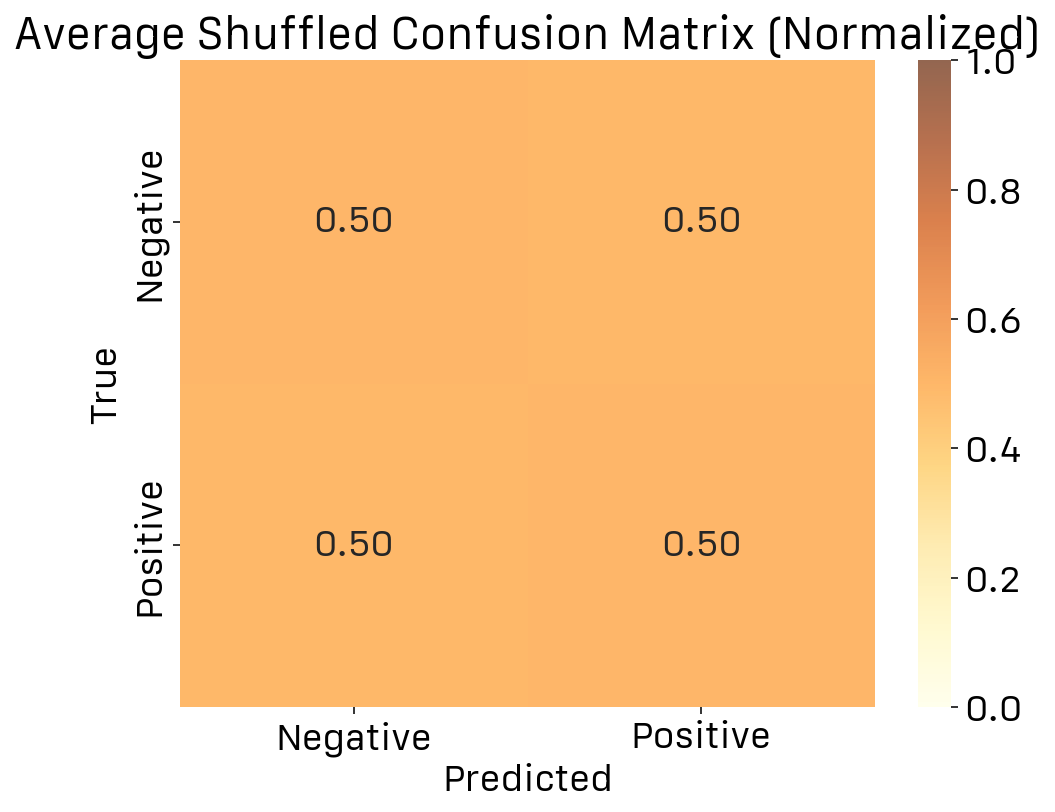

In [4]:
### DECODER OTHER EXPLO NEURO VS ASTRO 

#SAM
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/sam/preprocessed'
sam_files = glob.glob(os.path.join(directory, "*.csv"))

sam_files

#EPM 
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/epm/JrGECO_EPM/preprocessed'
epm_files = glob.glob(os.path.join(directory, "*.csv"))

epm_files


#Ymaze

directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/jRGECO/ymaze/preprocessed'
ymaze_files = glob.glob(os.path.join(directory, "*.csv"))

ymaze_files


# Initialize results storage
confusion_matrices = []
confusion_matrices_neuro = []
shuffled_confusion_matrices = []
shuffled_confusion_matrices_neuro = []

results = {'ID': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': [], '1_f1': [], '0_f1': [], 'AUC_ROC': [], 'Neuro_Accuracy': [], 
              'Neuro_Precision': [], 'Neuro_Recall': [], 'Neuro_F1': [], 'Neuro_1_f1': [], 'Neuro_0_f1': [], 'Neuro_AUC_ROC': [],
           'Shuffled_ID': [], 'Shuffled_Accuracy': [], 'Shuffled_Precision': [], 'Shuffled_Recall': [],
           'Shuffled_F1': [], 'Shuffled_1_f1': [], 'Shuffled_0_f1': [], 'Shuffled_AUC_ROC': [], 
           'Neuro_Shuffled_Accuracy': [], 'Neuro_Shuffled_Precision': [], 'Neuro_Shuffled_Recall': [],
           'Neuro_Shuffled_F1': [], 'Neuro_Shuffled_1_f1': [], 'Neuro_Shuffled_0_f1': [], 'Neuro_Shuffled_AUC_ROC': []}

num_repeats = 10  # number of under-sampling repeats


for efile, sfile, yfile in zip(epm_files, sam_files, ymaze_files):
    epm = pd.read_csv(efile)
    sam = pd.read_csv(sfile)

    ym = pd.read_csv(yfile)

    id=epm['ID'].iloc[0]

    # Preprocess epm data
    epm.loc[epm['In Closed Arms'] == 1, 'exploration'] = 0
    epm.loc[epm['In Closed Arms'] == 0, 'exploration'] = 1
    epm = epm[['Zscoreg', 'Zscorer', 'Time', 'exploration', 'ID']]

    # Preprocess sam data
    sam.loc[sam['In black'] == 1, 'exploration'] = 0
    sam.loc[sam['In black'] == 0, 'exploration'] = 1
    sam = sam[['Zscoreg', 'Zscorer', 'Time', 'exploration', 'ID']]

    # Concat epm + sam
    epm_sam = pd.concat([epm, sam], axis=0)


    # Preprocess ym data


    ym['In farm'] = 0
    ym.loc[(ym['In larm'] == 1) | (ym['In rarm'] == 1), 'In farm'] = 1


  
    explostart = ym[(ym['In Novelarm'].shift() == 0) & (ym['In Novelarm'] == 1)].index[0]
    exploend = ym[(ym['In Novelarm'].shift() == 1) & (ym['In Novelarm'] == 0)].index[0]

    ymtest = ym.loc[explostart:]

    nexplostart = ymtest[(ymtest['In farm'].shift() == 0) & (ymtest['In farm'] == 1)].index
    nexploend = ymtest[(ymtest['In farm'].shift() == 1) & (ymtest['In farm'] == 0)].index

    validnexplostart = []
    validnexploend = []

    for start, end in zip(nexplostart, nexploend):
        if end-start > 300:  ### keep only the first explo that fits the 5 seconds criterion
            validnexplostart.append(start)
            validnexploend.append(end)


    ymfirstexplo = pd.concat([ym.loc[explostart:exploend], ym.loc[validnexplostart[0]:validnexploend[0]]])


    ymfirstexplo['exploration'] = 0
    ymfirstexplo.loc[ymfirstexplo['In Novelarm'] == 1, 'exploration'] = 1

    ### dataset against other explo 

    ymotherexplo = ym.loc[validnexploend[0]:]
    ymotherexplo = ymotherexplo[(ymotherexplo['In Novelarm'] == 1) | (ymotherexplo['In farm'] == 1)]


    ymotherexplo['exploration'] = 0
    ymotherexplo.loc[ymotherexplo['In Novelarm'] == 1, 'exploration'] = 1
    ymotherexplo.loc[ymotherexplo['In farm'] == 1, 'exploration'] = 0



    # Parameters
    window_size = 300  # Sliding window size

    # Prepare training and testing datasets
    X_train, y_train = create_sliding_window(epm_sam, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    neuro_X_train, neuro_y_train = create_sliding_window(epm_sam, signal_col='Zscorer', target_col='exploration', window_size=window_size)
    X_testfirstexplo, y_testfirstexplo = create_sliding_window(ymotherexplo, signal_col='Zscoreg', target_col='exploration', window_size=window_size)
    neuro_X_testfirstexplo, neuro_y_testfirstexplo = create_sliding_window(ymotherexplo, signal_col='Zscorer', target_col='exploration', window_size=window_size)

    for repeat_idx in range(num_repeats):
        print(f"Repeat {repeat_idx + 1}/{num_repeats}")

        ## Model training ##############################

        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)

        # Get best model
        best_model = grid_search.best_estimator_
        best_model.fit(X_train_resampled, y_train_resampled)

         ## Model evaluation FIRST explo ##############################

        # Predict probabilities for AUC-ROC calculation
        y_pred_proba = best_model.predict_proba(X_testfirstexplo)

        y_pred = best_model.predict(X_testfirstexplo)

        # Compute AUC-ROC
        auc_roc = roc_auc_score(y_testfirstexplo, y_pred_proba[:, 1])

        # Evaluate model
        cm = confusion_matrix(y_testfirstexplo, y_pred, normalize='true')
        confusion_matrices.append(cm)

        report = classification_report(y_testfirstexplo, y_pred, output_dict=True)
        results['ID'].append(id)
        results['Accuracy'].append(report['accuracy'])
        results['Precision'].append(report['weighted avg']['precision'])
        results['Recall'].append(report['weighted avg']['recall'])
        results['F1'].append(report['weighted avg']['f1-score'])
        results['1_f1'].append(report['1']['f1-score'])
        results['0_f1'].append(report['0']['f1-score'])
        results['AUC_ROC'].append(auc_roc)


        # Shuffle and evaluate
        num_permutations = 50
        shuffled_cm_list = []
        shuffled_results_list = []

        for i in range(num_permutations):
            np.random.seed(42 + i)
            np.random.shuffle(y_train_resampled)

            ####### astrocytes

            best_model.fit(X_train_resampled, y_train_resampled)
            y_pred_shuffled_proba = best_model.predict_proba(X_testfirstexplo)
            y_pred_shuffled = best_model.predict(X_testfirstexplo)

            shuffled_auc_roc = roc_auc_score(y_testfirstexplo, y_pred_shuffled_proba[:, 1])

            shuffled_report = classification_report(y_testfirstexplo, y_pred_shuffled, output_dict=True)
            shuffled_results_list.append({
                'Shuffled_Accuracy': shuffled_report['accuracy'],
                'Shuffled_Precision': shuffled_report['weighted avg']['precision'],
                'Shuffled_Recall': shuffled_report['weighted avg']['recall'],
                'Shuffled_F1': shuffled_report['weighted avg']['f1-score'],
                'Shuffled_1_f1': shuffled_report['1']['f1-score'],
                'Shuffled_0_f1': shuffled_report['0']['f1-score'],
                'Shuffled_AUC_ROC': shuffled_auc_roc
            })

            cm_shuffled = confusion_matrix(y_testfirstexplo, y_pred_shuffled, normalize='true')
            shuffled_cm_list.append(cm_shuffled)


        avg_shuffled_cm = np.mean(shuffled_cm_list, axis=0)
        shuffled_average_results = {
            key: np.mean([res[key] for res in shuffled_results_list]) for key in shuffled_results_list[0]
        }
        results['Shuffled_ID'].append(id)
        results['Shuffled_Accuracy'].append(shuffled_average_results['Shuffled_Accuracy'])
        results['Shuffled_Precision'].append(shuffled_average_results['Shuffled_Precision'])
        results['Shuffled_Recall'].append(shuffled_average_results['Shuffled_Recall'])
        results['Shuffled_F1'].append(shuffled_average_results['Shuffled_F1'])
        results['Shuffled_1_f1'].append(shuffled_average_results['Shuffled_1_f1'])
        results['Shuffled_0_f1'].append(shuffled_average_results['Shuffled_0_f1'])
        results['Shuffled_AUC_ROC'].append(shuffled_average_results['Shuffled_AUC_ROC'])


        shuffled_confusion_matrices.append(avg_shuffled_cm)

        ### NEURO PART #####

        # Random undersampling
        undersampler = RandomUnderSampler(random_state=repeat_idx, sampling_strategy=1)
        neuro_X_train_resampled, neuro_y_train_resampled = undersampler.fit_resample(neuro_X_train, neuro_y_train)

        # Hyperparameter tuning
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
        lr_model = LogisticRegression(penalty='l2', random_state=42, max_iter=5000, class_weight='balanced', solver='liblinear')
        grid_search = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(neuro_X_train_resampled, neuro_y_train_resampled)

        # Get best model
        neuro_best_model = grid_search.best_estimator_
        neuro_best_model.fit(neuro_X_train_resampled, neuro_y_train_resampled)

        # Predict probabilities for AUC-ROC calculation
        neuro_y_pred_proba = neuro_best_model.predict_proba(neuro_X_testfirstexplo)
        neuro_y_pred = neuro_best_model.predict(neuro_X_testfirstexplo)

        # Compute AUC-ROC
        auc_roc2 = roc_auc_score(neuro_y_testfirstexplo, neuro_y_pred_proba[:, 1])

        # Evaluate model
        cm2 = confusion_matrix(neuro_y_testfirstexplo, neuro_y_pred, normalize='true')
        confusion_matrices_neuro.append(cm2)

        report = classification_report(neuro_y_testfirstexplo, neuro_y_pred, output_dict=True)
        results['Neuro_Accuracy'].append(report['accuracy'])
        results['Neuro_Precision'].append(report['weighted avg']['precision'])
        results['Neuro_Recall'].append(report['weighted avg']['recall'])
        results['Neuro_F1'].append(report['weighted avg']['f1-score'])
        results['Neuro_1_f1'].append(report['1']['f1-score'])
        results['Neuro_0_f1'].append(report['0']['f1-score'])
        results['Neuro_AUC_ROC'].append(auc_roc2)


        # Shuffle and evaluate
        num_permutations = 50
        shuffled_cm_list2 = []
        shuffled_results_list2 = []

        for i in range(num_permutations):
            np.random.seed(42 + i)
            np.random.shuffle(neuro_y_train_resampled)

            neuro_best_model.fit(neuro_X_train_resampled, neuro_y_train_resampled)
            neuro_y_pred_shuffled_proba = neuro_best_model.predict_proba(neuro_X_testfirstexplo)
            neuro_y_pred_shuffled = neuro_best_model.predict(neuro_X_testfirstexplo)

            shuffled_auc_roc2 = roc_auc_score(neuro_y_testfirstexplo, neuro_y_pred_shuffled_proba[:, 1])

            shuffled_report2 = classification_report(neuro_y_testfirstexplo, neuro_y_pred_shuffled, output_dict=True)
            
            shuffled_results_list2.append({
                'Shuffled_Accuracy2': shuffled_report2['accuracy'],
                'Shuffled_Precision2': shuffled_report2['weighted avg']['precision'],
                'Shuffled_Recall2': shuffled_report2['weighted avg']['recall'],
                'Shuffled_F12': shuffled_report2['weighted avg']['f1-score'],
                'Shuffled_1_f12': shuffled_report2['1']['f1-score'],
                'Shuffled_0_f12': shuffled_report2['0']['f1-score'],
                'Shuffled_AUC_ROC2': shuffled_auc_roc2
            })

            cm_shuffled2 = confusion_matrix(neuro_y_testfirstexplo, neuro_y_pred_shuffled, normalize='true')
            shuffled_cm_list2.append(cm_shuffled2)

        avg_shuffled_cm2 = np.mean(shuffled_cm_list2, axis=0)
        shuffled_average_results2 = {
            key: np.mean([res[key] for res in shuffled_results_list2]) for key in shuffled_results_list2[0]
        }

        results['Neuro_Shuffled_Accuracy'].append(shuffled_average_results2['Shuffled_Accuracy2'])
        results['Neuro_Shuffled_Precision'].append(shuffled_average_results2['Shuffled_Precision2'])
        results['Neuro_Shuffled_Recall'].append(shuffled_average_results2['Shuffled_Recall2'])
        results['Neuro_Shuffled_F1'].append(shuffled_average_results2['Shuffled_F12'])
        results['Neuro_Shuffled_1_f1'].append(shuffled_average_results2['Shuffled_1_f12'])
        results['Neuro_Shuffled_0_f1'].append(shuffled_average_results2['Shuffled_0_f12'])
        results['Neuro_Shuffled_AUC_ROC'].append(shuffled_average_results2['Shuffled_AUC_ROC2'])

        shuffled_confusion_matrices_neuro.append(avg_shuffled_cm2)



# Average confusion matrices
average_cm = np.mean(confusion_matrices, axis=0)
average_cm2 = np.mean(confusion_matrices_neuro, axis=0)
shuffled_average_cm = np.mean(shuffled_confusion_matrices, axis=0)
shuffled_average_cm2 = np.mean(shuffled_confusion_matrices_neuro, axis=0)

# Calculate average results for each ID
average_results = pd.DataFrame(results).groupby('ID').mean()
print(average_results)

# Plot confusion matrices

#### DATA FIRST EXPLO
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (Normalized)')
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_firstexplo.pdf', format='pdf')
plt.show()


### DATA NEURO EXPLO
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm2, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix (Normalized)')
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_otherexplo.pdf', format='pdf')
plt.show()

### SHUFFLED FIRST EXPLO
plt.figure(figsize=(8, 6))
sns.heatmap(shuffled_average_cm, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Shuffled Confusion Matrix (Normalized)')
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_firstexploSHUFFLED.pdf', format='pdf')
plt.show()

### SHUFFLED NEURO FIRST EXPLO

plt.figure(figsize=(8, 6))
sns.heatmap(shuffled_average_cm2, annot=True, fmt='.2f', cmap='YlOrBr', alpha=0.7, vmin=0, vmax=1,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Shuffled Confusion Matrix (Normalized)')
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/EPMSAM_CM_otherexploSHUFFLED.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   0.614623   0.684467  0.614623  0.637470  0.404929  0.714983  0.670986   
64   0.415873   0.700917  0.415873  0.328860  0.219829  0.532055  0.449279   
65   0.425490   0.405891  0.425490  0.412010  0.252393  0.533100  0.306230   
66   0.606897   0.541566  0.606897  0.571894  0.016903  0.754066  0.512835   
67   0.541270   0.504507  0.541270  0.521762  0.062050  0.696251  0.435879   
68   0.616327   0.459622  0.616327  0.526552  0.000000  0.762592  0.444806   
71   0.602439   0.532079  0.602439  0.555835  0.150386  0.739868  0.620545   
84   0.677215   0.458620  0.677215  0.546883  0.000000  0.807547  0.379677   
151  0.604306   0.789362  0.604306  0.680365  0.067692  0.748802  0.584321   
152  0.260000   0.209709  0.260000  0.194538  0.076664  0.382540  0.225166   

     Neuro_Accuracy  Neuro_Precision  Neuro_Recall  ...  Shuffl

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_87123/1891057904.py:29: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


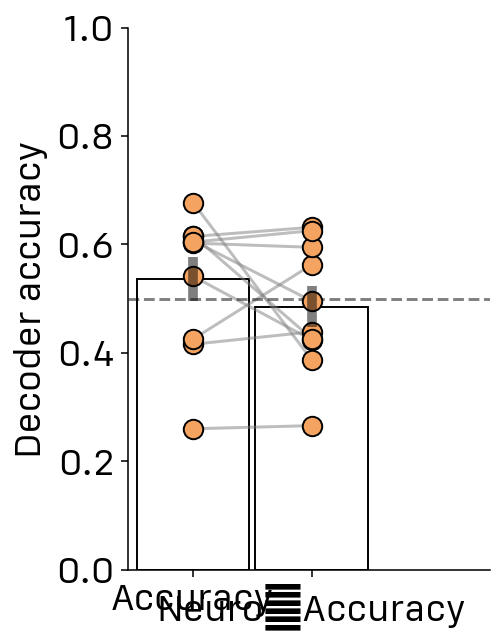

In [11]:
df = pd.DataFrame(average_results)
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['Accuracy', 'Neuro_Accuracy']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Accuracy'], df['Neuro_Accuracy'])
print(ttest_results)

print('ASTRO VS SHUFFLED', ttest_ind(df['Accuracy'], df['Shuffled_Accuracy']) )
print('NEURO VS SHUFFLED', ttest_ind(df['Neuro_Accuracy'], df['Neuro_Shuffled_Accuracy']) )

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Accuracy'], row['Neuro_Accuracy']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder accuracy')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeOTHER_Accuracy.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   0.614623   0.684467  0.614623  0.637470  0.404929  0.714983  0.670986   
64   0.415873   0.700917  0.415873  0.328860  0.219829  0.532055  0.449279   
65   0.425490   0.405891  0.425490  0.412010  0.252393  0.533100  0.306230   
66   0.606897   0.541566  0.606897  0.571894  0.016903  0.754066  0.512835   
67   0.541270   0.504507  0.541270  0.521762  0.062050  0.696251  0.435879   
68   0.616327   0.459622  0.616327  0.526552  0.000000  0.762592  0.444806   
71   0.602439   0.532079  0.602439  0.555835  0.150386  0.739868  0.620545   
84   0.677215   0.458620  0.677215  0.546883  0.000000  0.807547  0.379677   
151  0.604306   0.789362  0.604306  0.680365  0.067692  0.748802  0.584321   
152  0.260000   0.209709  0.260000  0.194538  0.076664  0.382540  0.225166   

     Neuro_Accuracy  Neuro_Precision  Neuro_Recall  ...  Shuffl

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_87123/1409050934.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_87123/1409050934.py:27: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeOTHER_F1.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


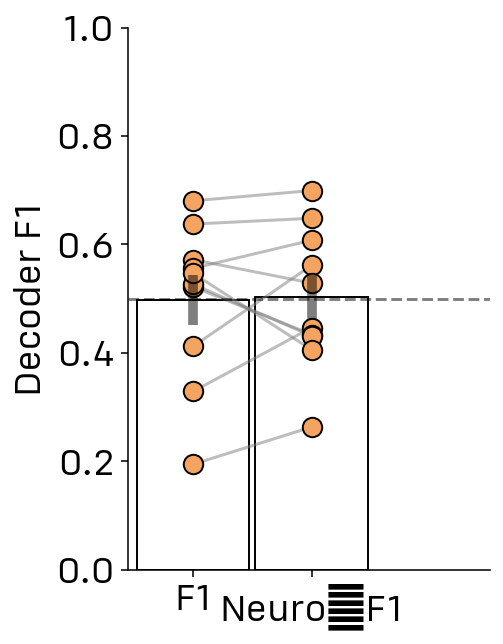

In [ ]:
df = pd.DataFrame(average_results)
df2=df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['F1', 'Neuro_F1']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['F1'], df['Neuro_F1'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['F1'], row['Neuro_F1']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder F1')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.tight_layout()
# plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeOTHER_F1.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   0.614623   0.684467  0.614623  0.637470  0.404929  0.714983  0.670986   
64   0.415873   0.700917  0.415873  0.328860  0.219829  0.532055  0.449279   
65   0.425490   0.405891  0.425490  0.412010  0.252393  0.533100  0.306230   
66   0.606897   0.541566  0.606897  0.571894  0.016903  0.754066  0.512835   
67   0.541270   0.504507  0.541270  0.521762  0.062050  0.696251  0.435879   
68   0.616327   0.459622  0.616327  0.526552  0.000000  0.762592  0.444806   
71   0.602439   0.532079  0.602439  0.555835  0.150386  0.739868  0.620545   
84   0.677215   0.458620  0.677215  0.546883  0.000000  0.807547  0.379677   
151  0.604306   0.789362  0.604306  0.680365  0.067692  0.748802  0.584321   
152  0.260000   0.209709  0.260000  0.194538  0.076664  0.382540  0.225166   

     Neuro_Accuracy  Neuro_Precision  Neuro_Recall  ...  Shuffl

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_87123/845203057.py:25: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_87123/845203057.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeOTHER_precision.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


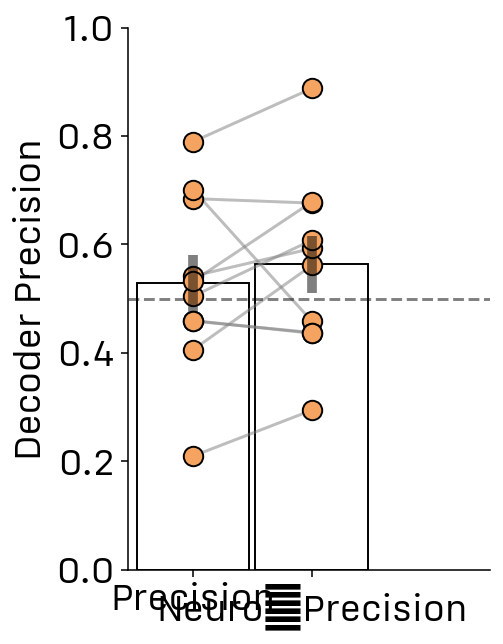

In [7]:
df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4, 5))
conditions = ['Precision', 'Neuro_Precision']
means = df[conditions].mean(axis=0)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['Precision'], df['Neuro_Precision'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
    zorder=0)
for condition in conditions:
    plt.scatter([condition] * len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Precision'], row['Neuro_Precision']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder Precision')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55, 3 - 0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeOTHER_precision.pdf', format='pdf')
plt.show()

Recall          0.536444
Neuro_Recall    0.485120
dtype: float64
Recall          0.040760
Neuro_Recall    0.037473
dtype: float64
TtestResult(statistic=np.float64(0.9269650496480131), pvalue=np.float64(0.36620788705456353), df=np.float64(18.0))


/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_87123/3059177690.py:27: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_87123/3059177690.py:28: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeOTHER_recall.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


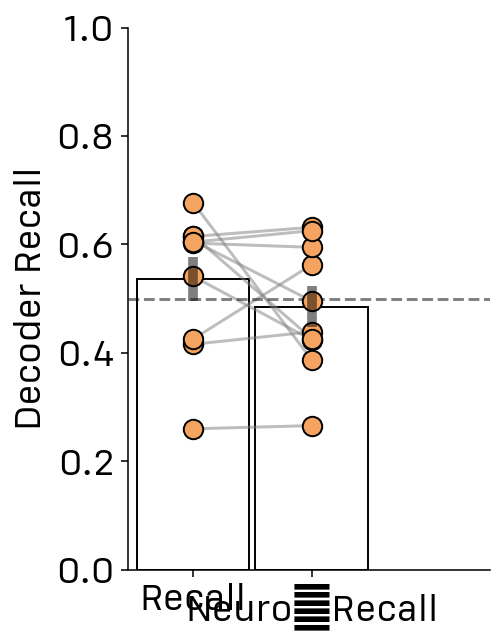

In [8]:

df = pd.DataFrame(average_results)
df2 = df.copy()
# print(df)

plt.figure(figsize=(4,5))
conditions = ['Recall', 'Neuro_Recall']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
print(sems)
ttest_results = ttest_ind(df['Recall'], df['Neuro_Recall'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['Recall'], row['Neuro_Recall']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder Recall')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeOTHER_recall.pdf', format='pdf')
plt.show()

     Accuracy  Precision    Recall        F1      1_f1      0_f1   AUC_ROC  \
ID                                                                           
63   0.614623   0.684467  0.614623  0.637470  0.404929  0.714983  0.670986   
64   0.415873   0.700917  0.415873  0.328860  0.219829  0.532055  0.449279   
65   0.425490   0.405891  0.425490  0.412010  0.252393  0.533100  0.306230   
66   0.606897   0.541566  0.606897  0.571894  0.016903  0.754066  0.512835   
67   0.541270   0.504507  0.541270  0.521762  0.062050  0.696251  0.435879   
68   0.616327   0.459622  0.616327  0.526552  0.000000  0.762592  0.444806   
71   0.602439   0.532079  0.602439  0.555835  0.150386  0.739868  0.620545   
84   0.677215   0.458620  0.677215  0.546883  0.000000  0.807547  0.379677   
151  0.604306   0.789362  0.604306  0.680365  0.067692  0.748802  0.584321   
152  0.260000   0.209709  0.260000  0.194538  0.076664  0.382540  0.225166   

     Neuro_Accuracy  Neuro_Precision  Neuro_Recall  ...  Shuffl

/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_87123/4047854248.py:26: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.tight_layout()
/var/folders/f5/1b9s96g507d8lm318wd11vrc0000gp/T/ipykernel_87123/4047854248.py:27: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeOTHER_AUCROC.pdf', format='pdf')
/Users/ossamaghenissa/fpenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 95 (_) missing from font(s) .SF Camera.
  fig.canvas.print_figure(bytes_io, **kw)


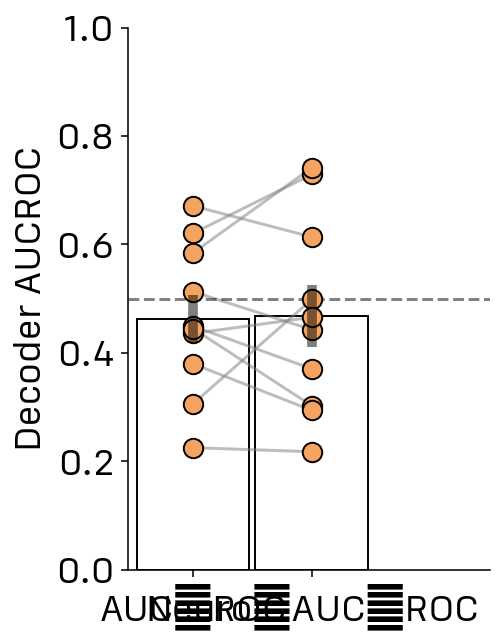

In [9]:

df = pd.DataFrame(average_results)
df2 = df.copy()
print(df)

plt.figure(figsize=(4,5))
conditions = ['AUC_ROC', 'Neuro_AUC_ROC']
means = df[conditions].mean(axis=0)
print(means)
sems = df[conditions].sem(axis=0)
ttest_results = ttest_ind(df['AUC_ROC'], df['Neuro_AUC_ROC'])
print(ttest_results)

plt.bar(conditions, means, yerr=sems, color='none', edgecolor='black', capsize=0, width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
            zorder=0)
for condition in conditions:
    plt.scatter([condition]*len(df), df[condition], color='sandybrown', edgecolor='black', s=100, zorder=3)
    for i, row in df.iterrows():
        plt.plot([conditions[0], conditions[1]], [row['AUC_ROC'], row['Neuro_AUC_ROC']], color='gray', alpha=0.3, zorder=1)

plt.ylabel('Decoder AUCROC')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
ax.set_xlim(-0.55,3-0.5)
plt.yticks([0, .2, .4, .6, .8, 1])
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/decoder/jrgeco/Ymaze/firstexplo/YmazeOTHER_AUCROC.pdf', format='pdf')
plt.show()